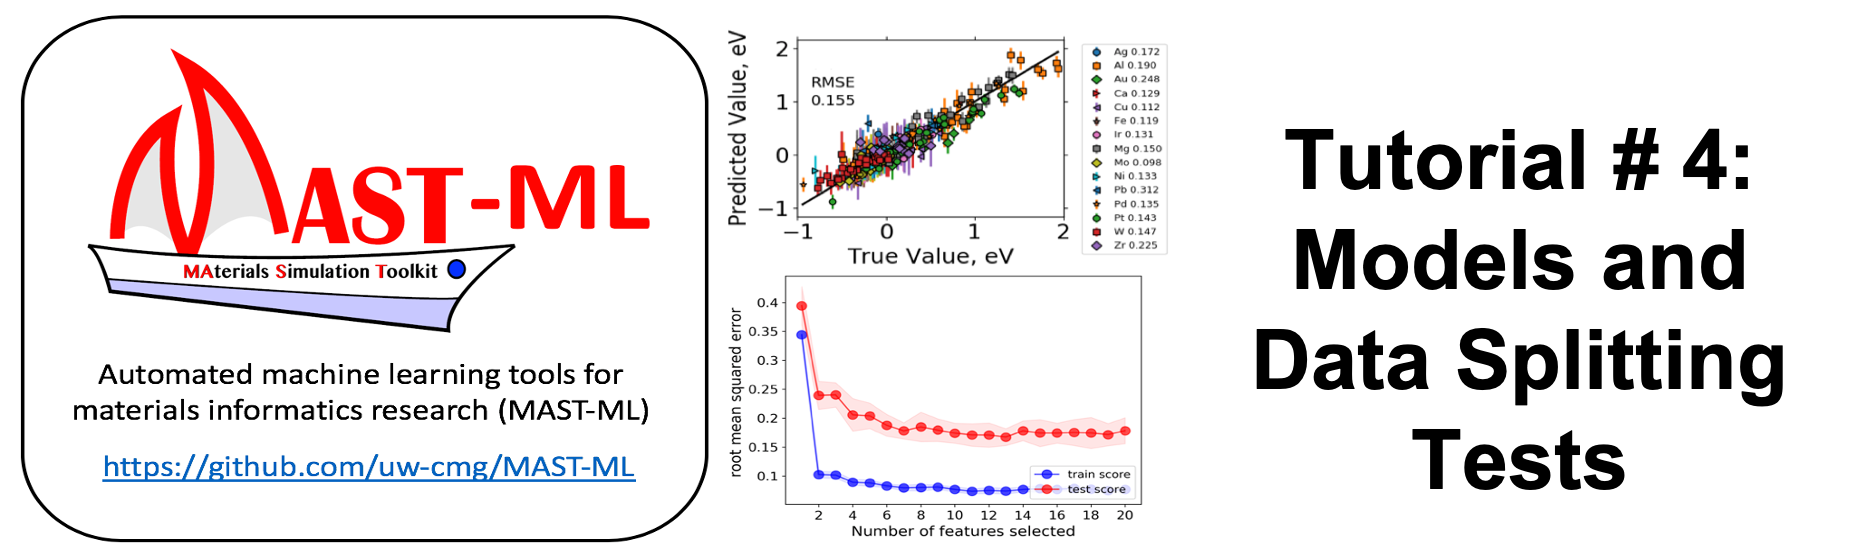

# Welcome to the fourth MAST-ML tutorial notebook, 

# Models and Data Splitting Tests with MAST-ML! 

## In this notebook, we will learn how to run a few different types of models on a select dataset, and conduct a few different types of data splits to evaluate our model performance. In this tutorial, we will:

1. [Set up MAST-ML on Colab and begin session](#task1)
2. [Run a variety of model types from the scikit-learn package](#task2)
3. [Run a bootstrapped ensemble of neural networks](#task3)
4. [Compare performance of scikit-learn's gradient boosting method and XGBoost](#task4)
5. [Compare performance of scikit-learn neural network and Keras-based neural network regressor](#task5)
6. [Compare model performance using random k-fold cross validation and leave out group cross validation](#task6)
7. [Explore the limits of model performance when up to 90% of data is left out using leave out percent cross validation](#task7)

## Task 1: Set up MAST-ML on Colab and begin session <a name="task1"></a>

If you are working on Google Colab and need to install MAST-ML, 
begin by pip installing MAST-ML to the Colab session
and install the needed dependencies:

In [1]:
!pip install mastml

     |████████████████████████████████| 122kB 12.8MB/s 
     |████████████████████████████████| 102kB 3.1MB/s 
     |████████████████████████████████| 92kB 7.2MB/s 
     |████████████████████████████████| 61kB 7.5MB/s 
     |████████████████████████████████| 81kB 8.9MB/s 
     |████████████████████████████████| 3.0MB 27.1MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 5.8MB 18.8MB/s 
     |████████████████████████████████| 51kB 7.6MB/s 
     |████████████████████████████████| 645kB 47.3MB/s 
     |████████████████████████████████| 13.2MB 49.5MB/s 
     |████████████████████████████████| 71kB 10.0MB/s 
     |████████████████████████████████| 256kB 37.2MB/s 
     |████████████████████████████████| 296kB 51.7MB/s 
     |████████████████████████████████| 102kB 12.6MB/s 
     |████████████████████████████████| 81kB 1.3MB/s 
  

Sync your Google drive to Colab so that we can save MAST-ML results to our Google
Drive. If we save to the Colab session, the data will be deleted when the session 
ends.

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Here we import the MAST-ML modules used in this tutorial

In [2]:
from mastml.mastml import Mastml
from mastml.datasets import LocalDatasets
from mastml.models import SklearnModel, EnsembleModel
from mastml.preprocessing import SklearnPreprocessor
from mastml.data_splitters import SklearnDataSplitter, NoSplit, LeaveOutPercent
import mastml
import os
data_path = os.path.join(mastml.__path__._path[0], 'data')
%tensorflow_version 1.x

/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


Figshare is an optional dependency. To import data from figshare, manually install figshare via git clone of git clone https://github.com/cognoma/figshare.git


Using TensorFlow backend.


forestci is an optional dependency. To install latest forestci compatabilty with scikit-learn>=0.24, run pip install git+git://github.com/scikit-learn-contrib/forest-confidence-interval.git


Here, we set the name of the savepath to save MAST-ML results to, and initialize
our MAST-ML run

When the above command is run, a new folder with the name designated SAVEPATH is created.
This is where all of the output for the current MAST-ML run will be saved to.
Note that you can perform multiple runs with the same folder name, and the current datetime
will be appended to the name so that no data is lost or overwritten.

In [3]:
SAVEPATH = 'drive/MyDrive/MASTML_tutorial_4_Models_and_Tests'

mastml = Mastml(savepath=SAVEPATH)
savepath = mastml.get_savepath

drive/MyDrive/MASTML_tutorial_4_Models_and_Tests not empty. Renaming...


## Task 2: Run a variety of model types from the scikit-learn package <a name="task2"></a>

In this tutorial, we will again use the diffusion dataset that we examined in the 
previous tutorial. Here, we use the LocalDatasets module to load in the diffusion dataset. 

In [4]:
target = 'E_regression'

extra_columns = ['Material compositions 1', 'Material compositions 2']

d = LocalDatasets(file_path=data_path+'/diffusion_data_selectfeatures.xlsx', 
                  target=target, 
                  extra_columns=extra_columns, 
                  group_column='Material compositions 1',
                  testdata_columns=None,
                  as_frame=True)

# Load the data with the load_data() method
data_dict = d.load_data()

# Let's assign each data object to its respective name
X = data_dict['X']
y = data_dict['y']
X_extra = data_dict['X_extra']
groups = data_dict['groups']
X_testdata = data_dict['X_testdata']

In the first part of this tutorial, we will assess the performance of a handful
of different types of regression models in scikit-learn using full fits and
random 5-fold cross validation. Let's try out the following models:

**Linear regression**
     
**Kernel ridge regression with Gaussian kernel**
     
**Gaussian process regressor**
     
**Random forest regressor**
     
**Neural network**

To make these models, we use the SklearnModel class. The scikit-learn model name 
can just be given as a string matching the model name in the "model" field. The 
remaining arguments are the parameters to pass to the model. If no parameters are given, 
default values are used.

In [10]:
model_lin = SklearnModel(model='LinearRegression')
model_gkrr = SklearnModel(model='KernelRidge', kernel='rbf')
model_gpr = SklearnModel(model='GaussianProcessRegressor', kernel='ConstantKernel*RBF', n_restarts_optimizer=10)
model_rf = SklearnModel(model='RandomForestRegressor', n_estimators=150)
model_nn = SklearnModel(model='MLPRegressor', hidden_layer_sizes=(20, 10))

MAST-ML takes a list of the models as input.

In [11]:
models = [model_lin, model_gkrr, model_gpr, model_rf, model_nn]

As in the previous tutorial, we need to define our preprocessing function. 
We are just going to use the basic StandardScaler in scikit-learn to normalize 
each column to have mean zero and standard deviation of one.

In [9]:
preprocessor = SklearnPreprocessor(preprocessor='StandardScaler', as_frame=True)

Finally, we list which metrics we want to evaluate. If none are given, MAST-ML
will default to evaulating just the root mean squared error. A complete list of 
metrics can be obtained from calling Metrics()._metric_zoo() in metrics.py.

In [10]:
metrics = ['r2_score', 'mean_absolute_error', 'root_mean_squared_error', 'rmse_over_stdev']

As a first run, we want to define and run the case where no data split is 
performed. This represents a full fit to all of the data. MAST-ML will automatically
fit all of our models in sequence.

Note that each splitter.evaluate() method has a verbosity tag- this tag controls 
the extent of analysis output plotting that is performed. A value of 3 is the highest,
meaning that the most output is produced

In [14]:
splitter = NoSplit()
splitter.evaluate(X=X,
                  y=y, 
                  models=models,
                  preprocessor=preprocessor,
                  metrics=metrics,
                  savepath=savepath,
                  X_extra=X_extra,
                  plots = ['Scatter', 'Histogram'],
                  verbosity=3)

After performing this run, we see from our output folders that a new folder for each
model is created, and we can see that NoSplit was performed based on its naming convention.
Note there is only one split folder for these runs because no data split was performed, i.e.
all data was used as train and test

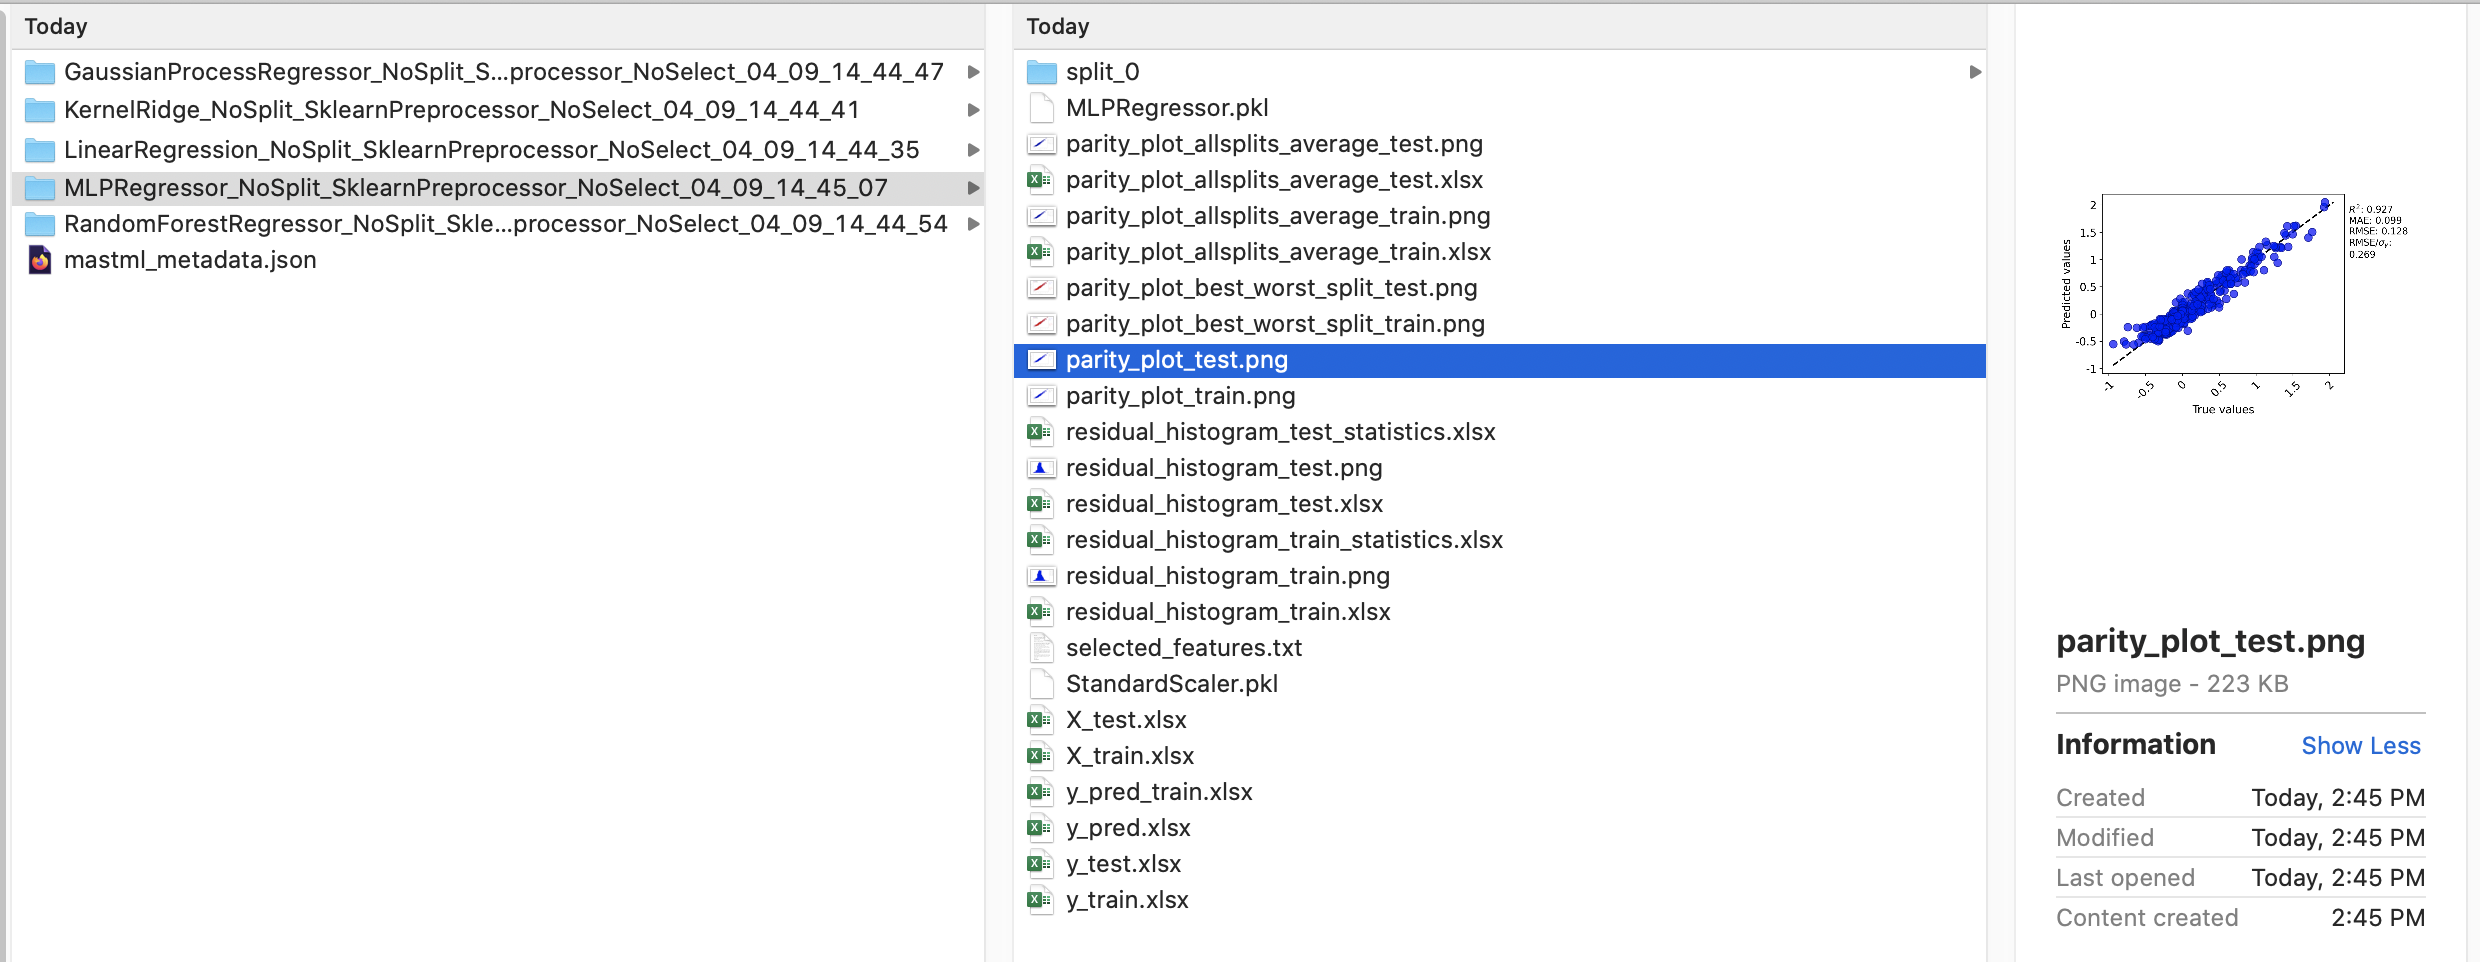

Next, we want to do something a bit more informative than simply fitting to 
all of our data. We will do a random leave-out cross validation test (5-fold CV). 
MAST-ML will output data and plots for each split as well as some more comprehensive analysis 
performed over all splits. The saved model and preprocessor corresponding to the best 
split will also be put in the data splitter parent directory, and this saved model
can be imported for use in future predictions 

In [15]:
splitter = SklearnDataSplitter(splitter='RepeatedKFold', n_repeats=1, n_splits=5)
splitter.evaluate(X=X,
                  y=y, 
                  models=models,
                  preprocessor=preprocessor,
                  metrics=metrics,
                  plots=['Scatter', 'Histogram'],
                  savepath=savepath,
                  X_extra=X_extra,
                  verbosity=3)

MAST-ML saves output with a folder format of ModelName_DataSplitterName_PreprocessorName_FeatureSelectorName_Datetime
Examine the output of each model for the 5-fold CV runs. You'll see there are folders corresponding to each
split that was performed. In each of these split folders, the X and y train/test splits are saved as spreadsheets,
as well as the preprocessed data used for fitting. In addition, data on the residuals, a residuals histogram, and 
parity plots for both train and test data are provided. There are also some files pertaining to the estimated model
errors for certain models (GPR, Random forest), but we'll discuss those more in Tutorial 6. 

In the main data splitter directory, there are summary-level plots of residual histograms and data over all splits,
and train and test parity plots, again taken over all splits. There are a few varieties of parity plots that may
be of interest:

**parity_plot_allsplits_average_(train/test).png**: This plot is pred vs. true values, one point per unique true data point. The average test value of each point is plotted, so leaving out the same point multiple times gives an error bar.

**parity_plot_best_worst_eachpoint_(train/test).png**: Parity plot where each point is the best or worst prediction over all the splits for that particular data point.

**parity_plot_best_worst_split_(train/test).png**: Parity plot where the data series pertain to the best and worst individual splits.

**parity_plot_(train/test).png**: Parity plot showing all the data points from all splits, without averaging values for each unique true data point.



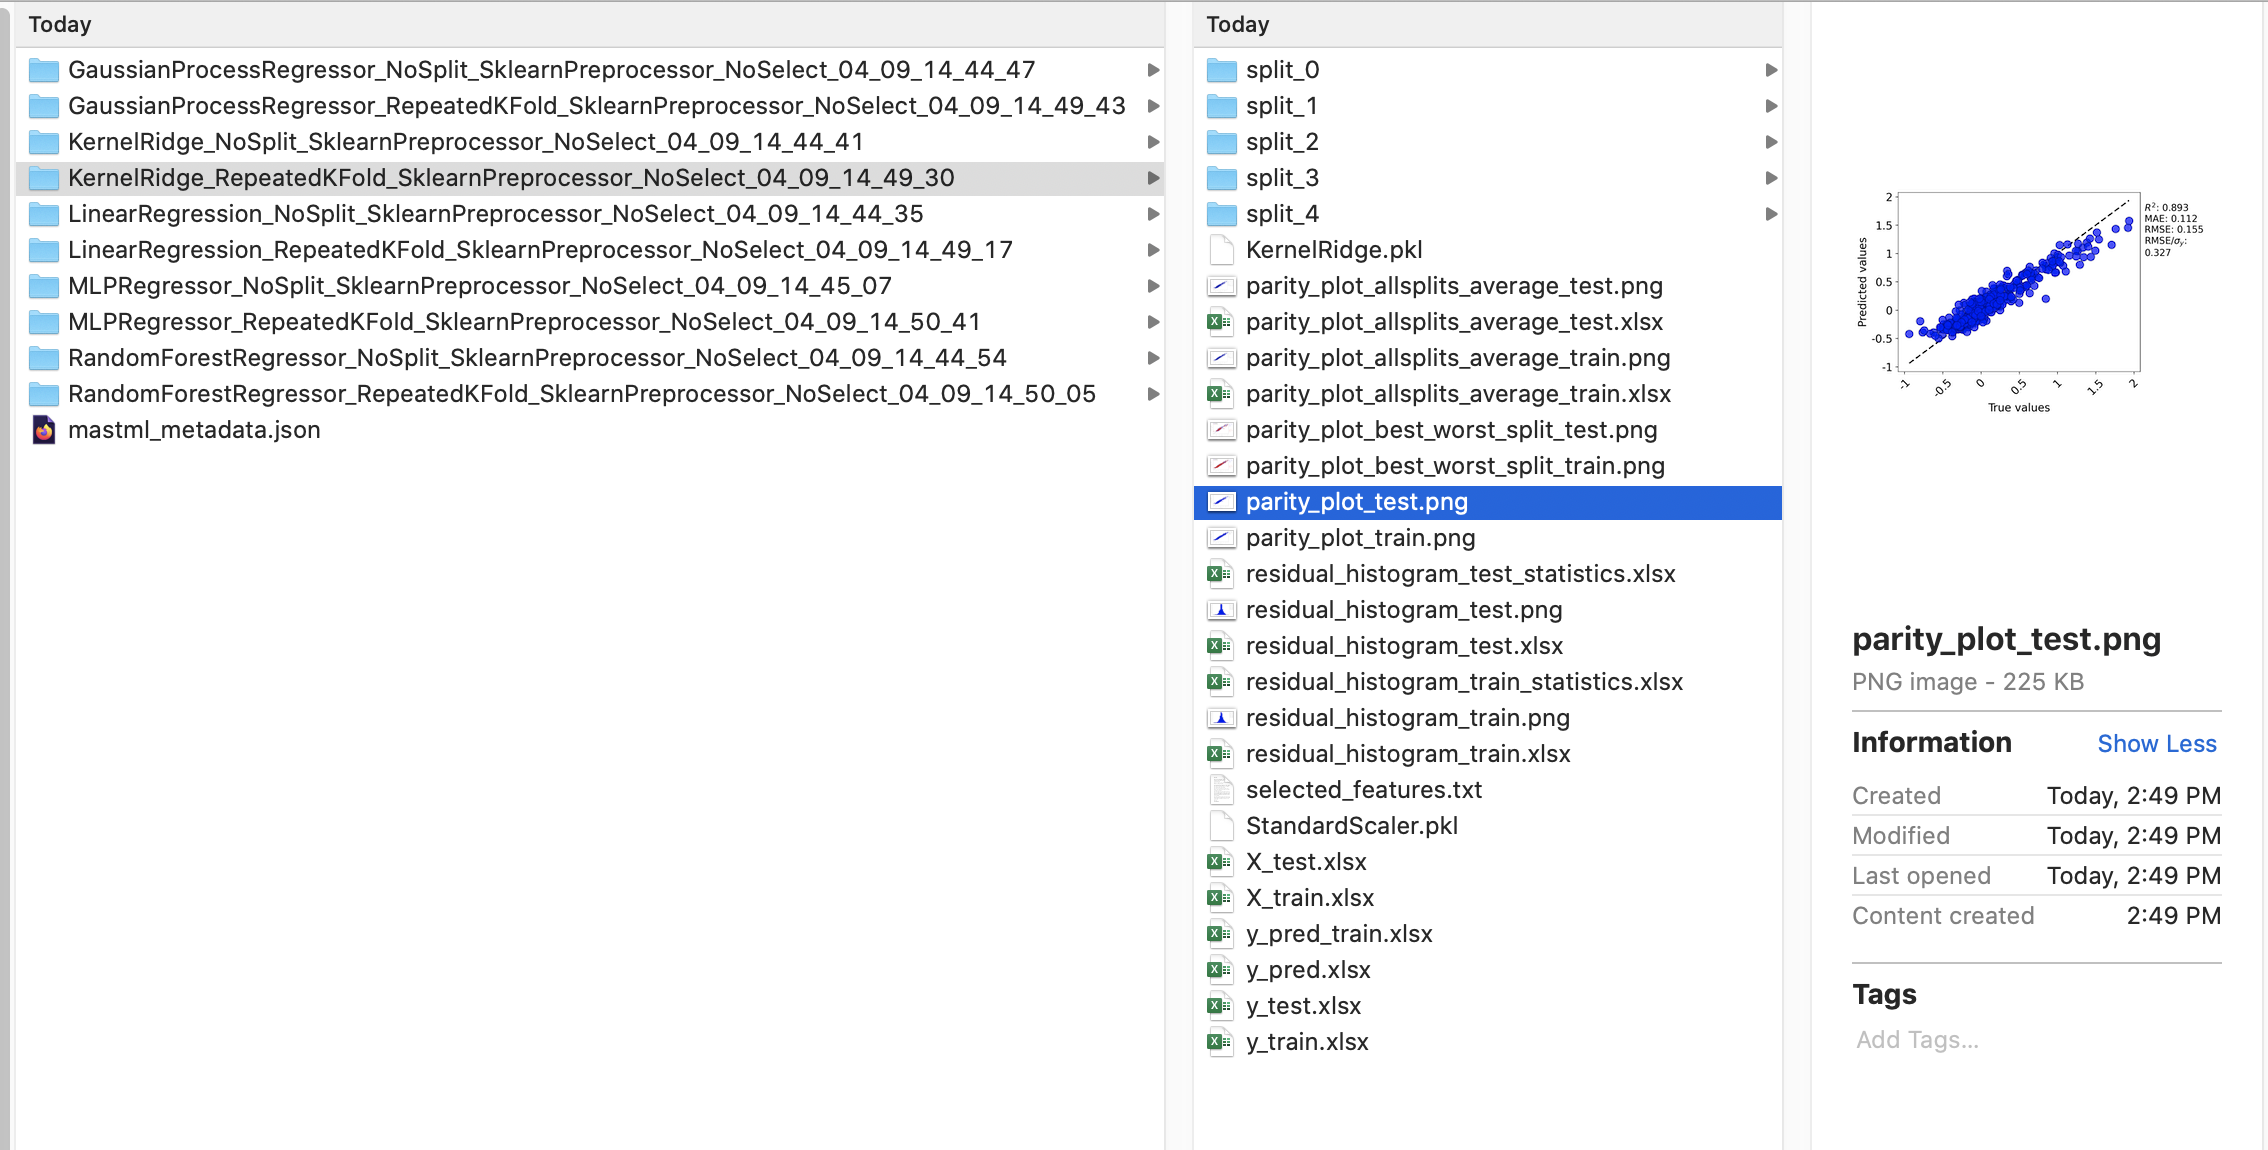

Which model performed the best? We can look at the test data parity plots of each model to see:

### Gaussian Process Regression
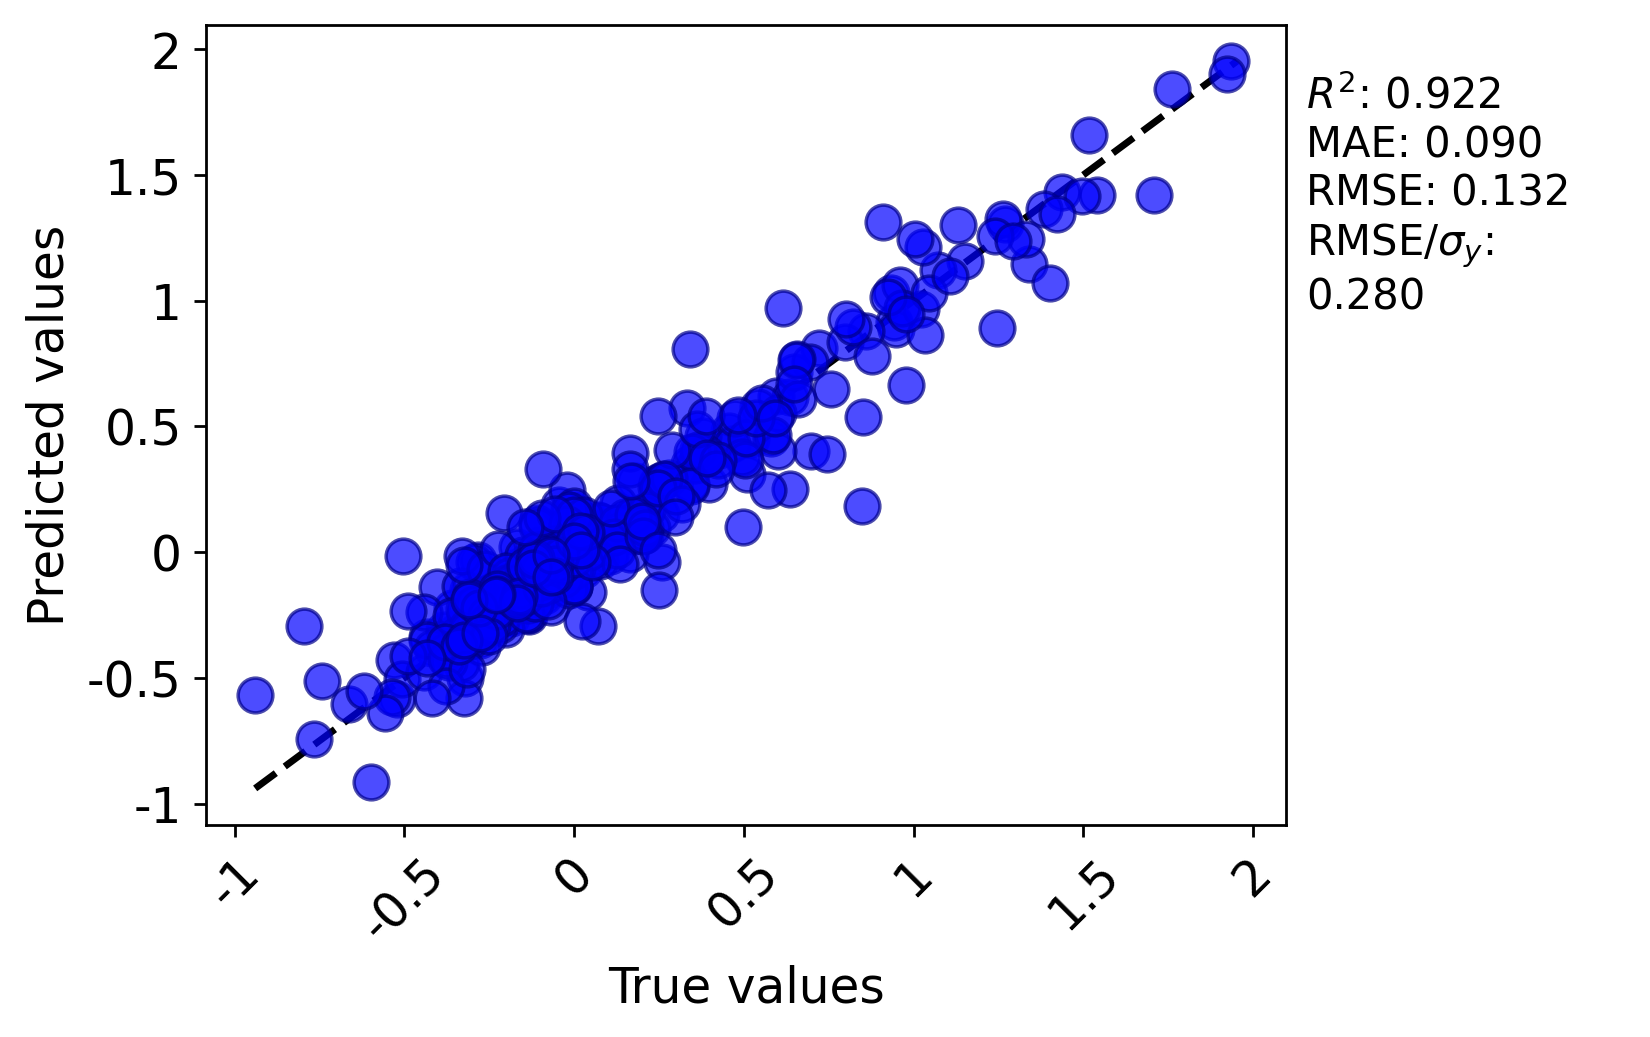

### Kernel Ridge Regression
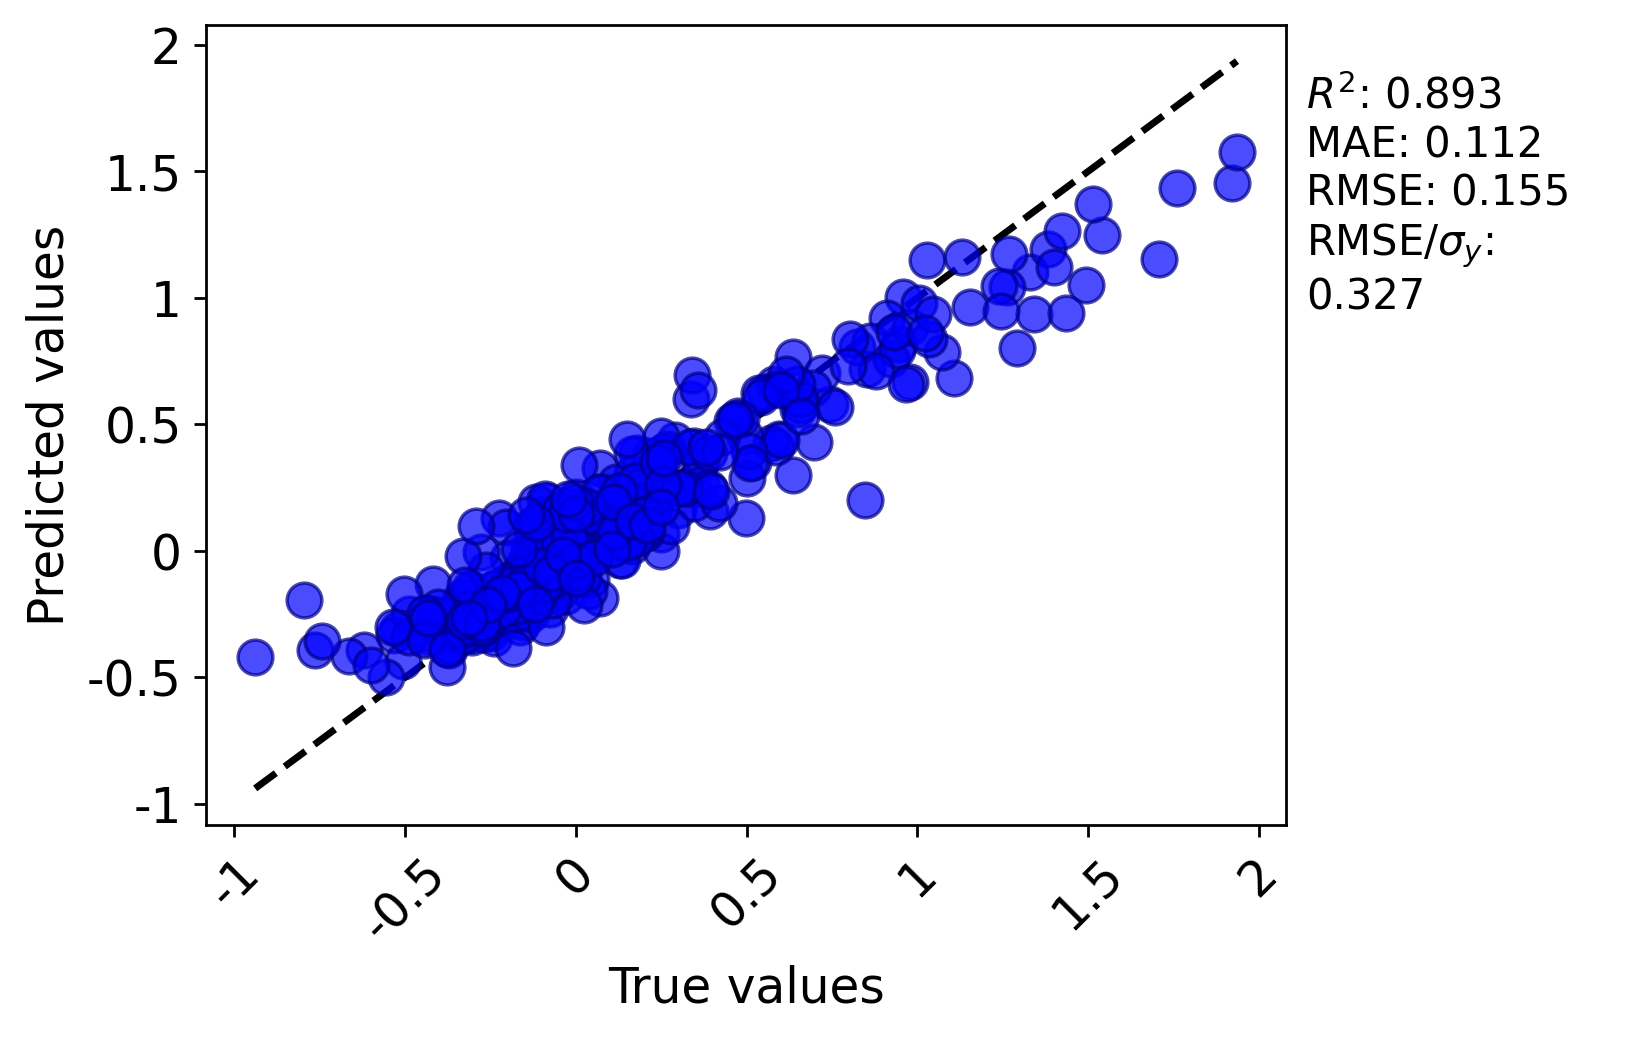

### Linear Regression
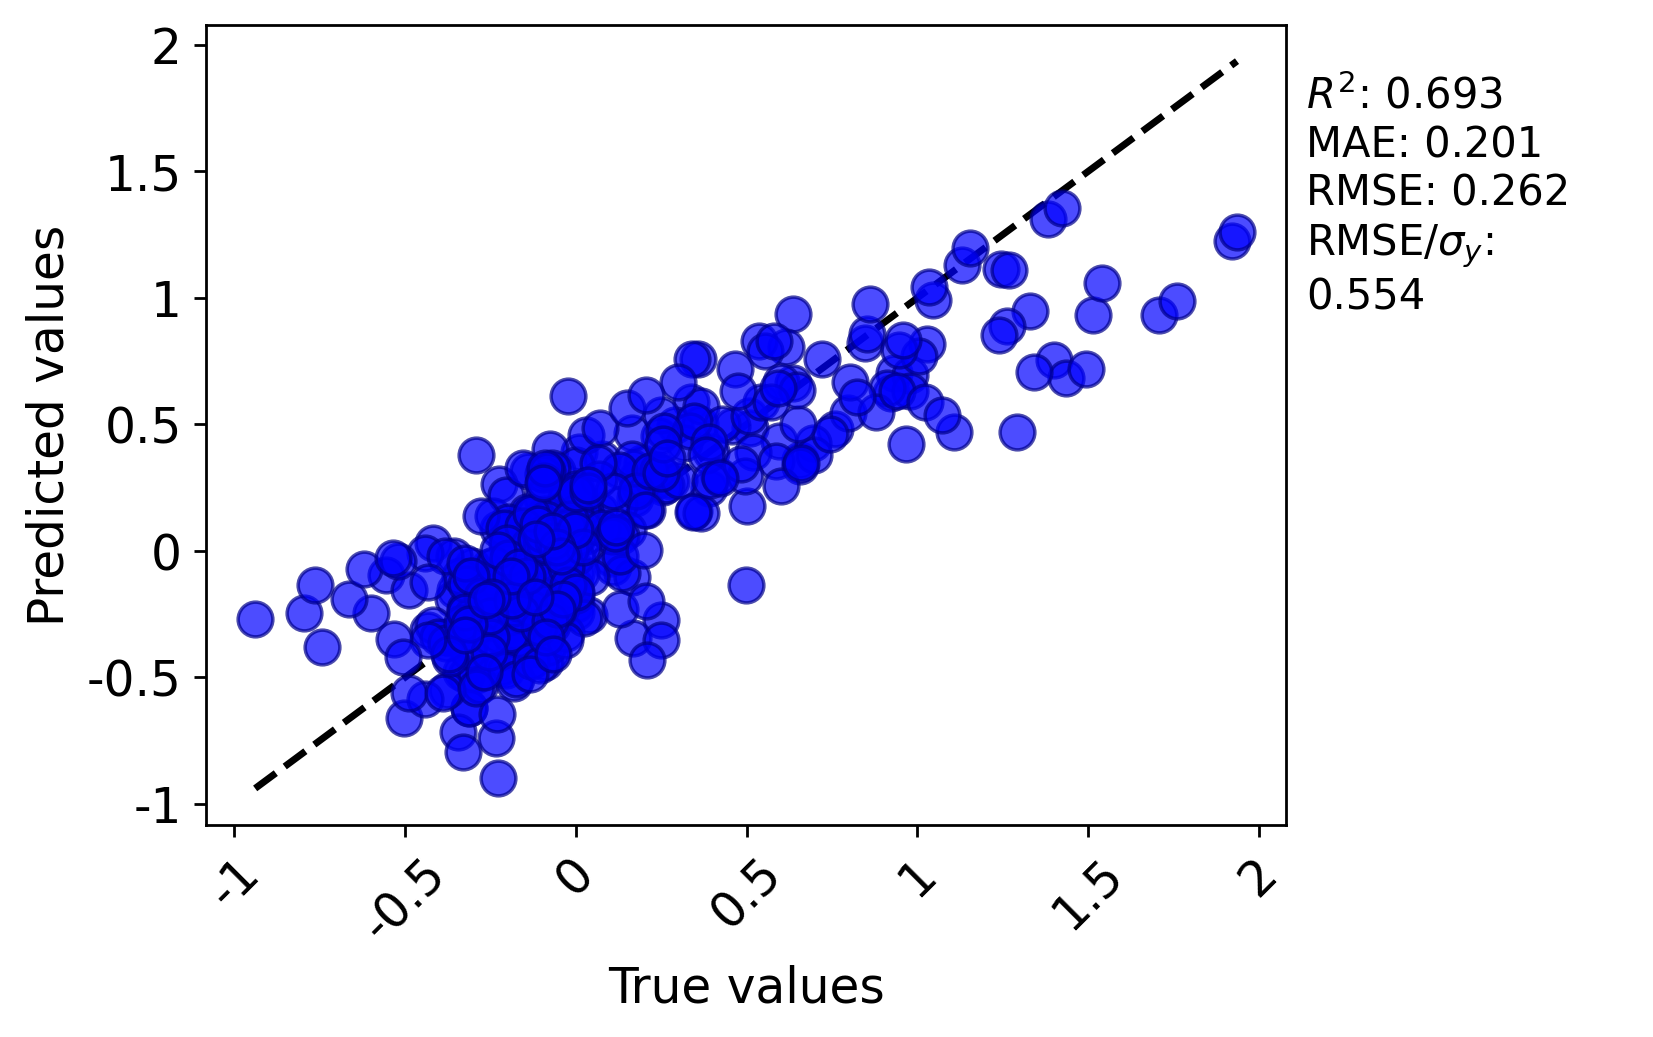

### Neural Network
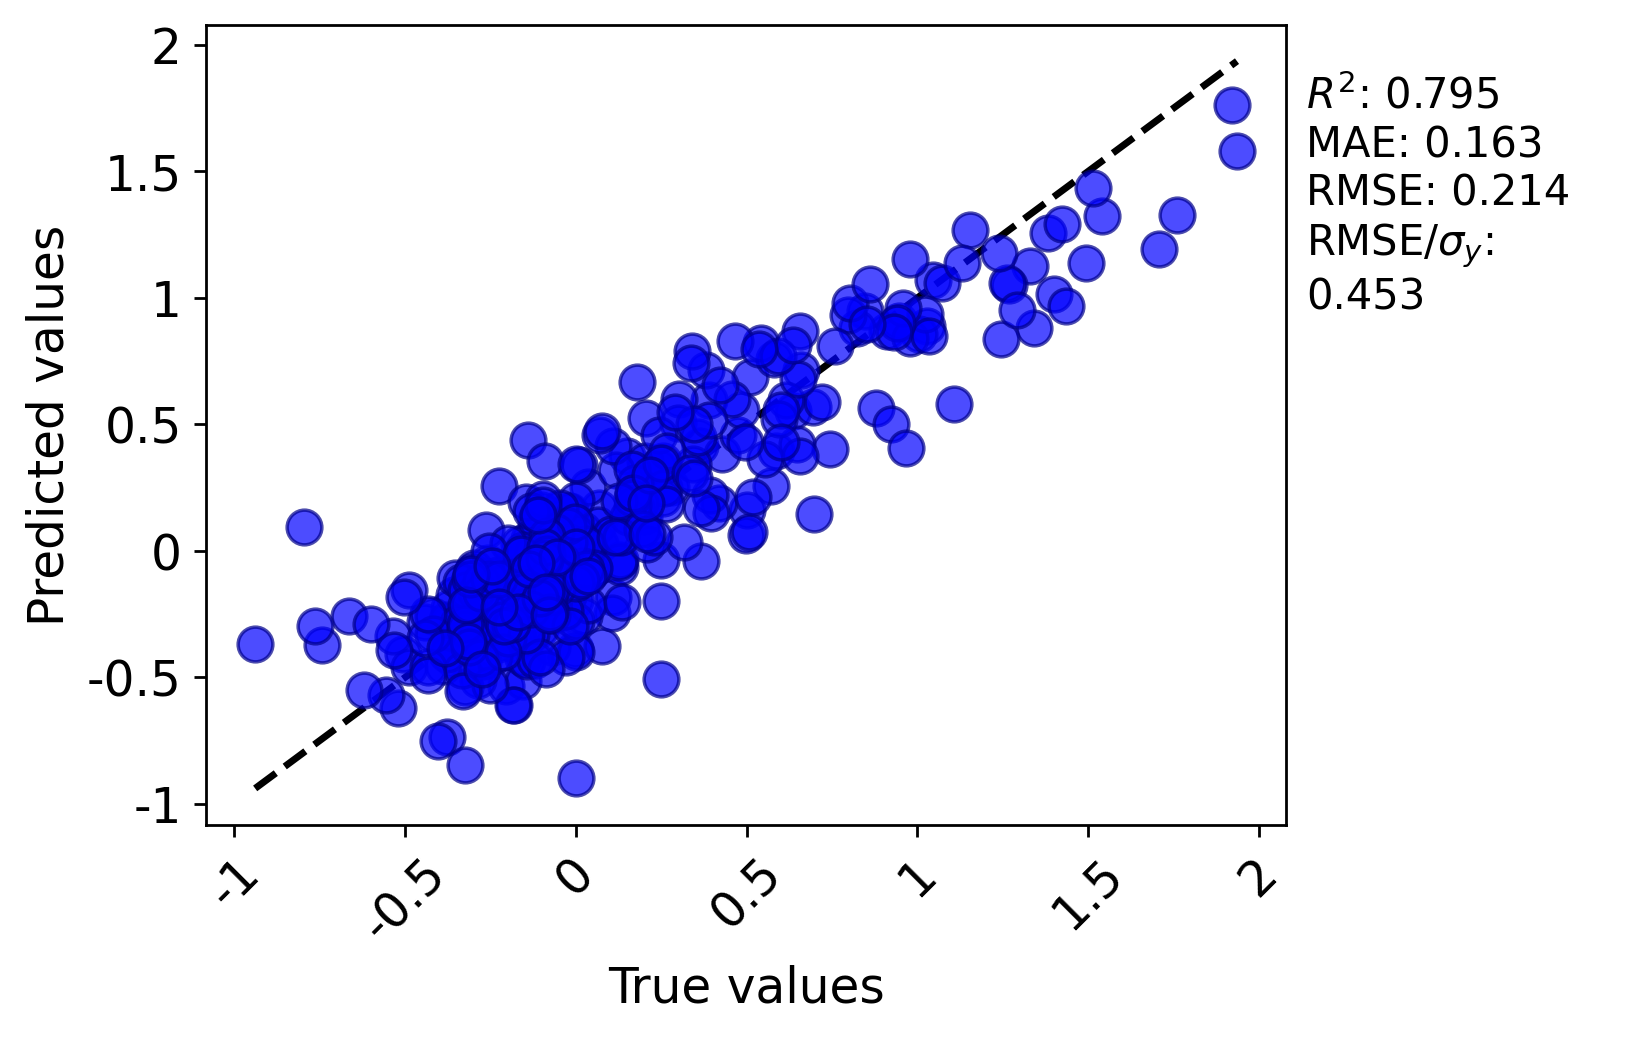

### Random Forest
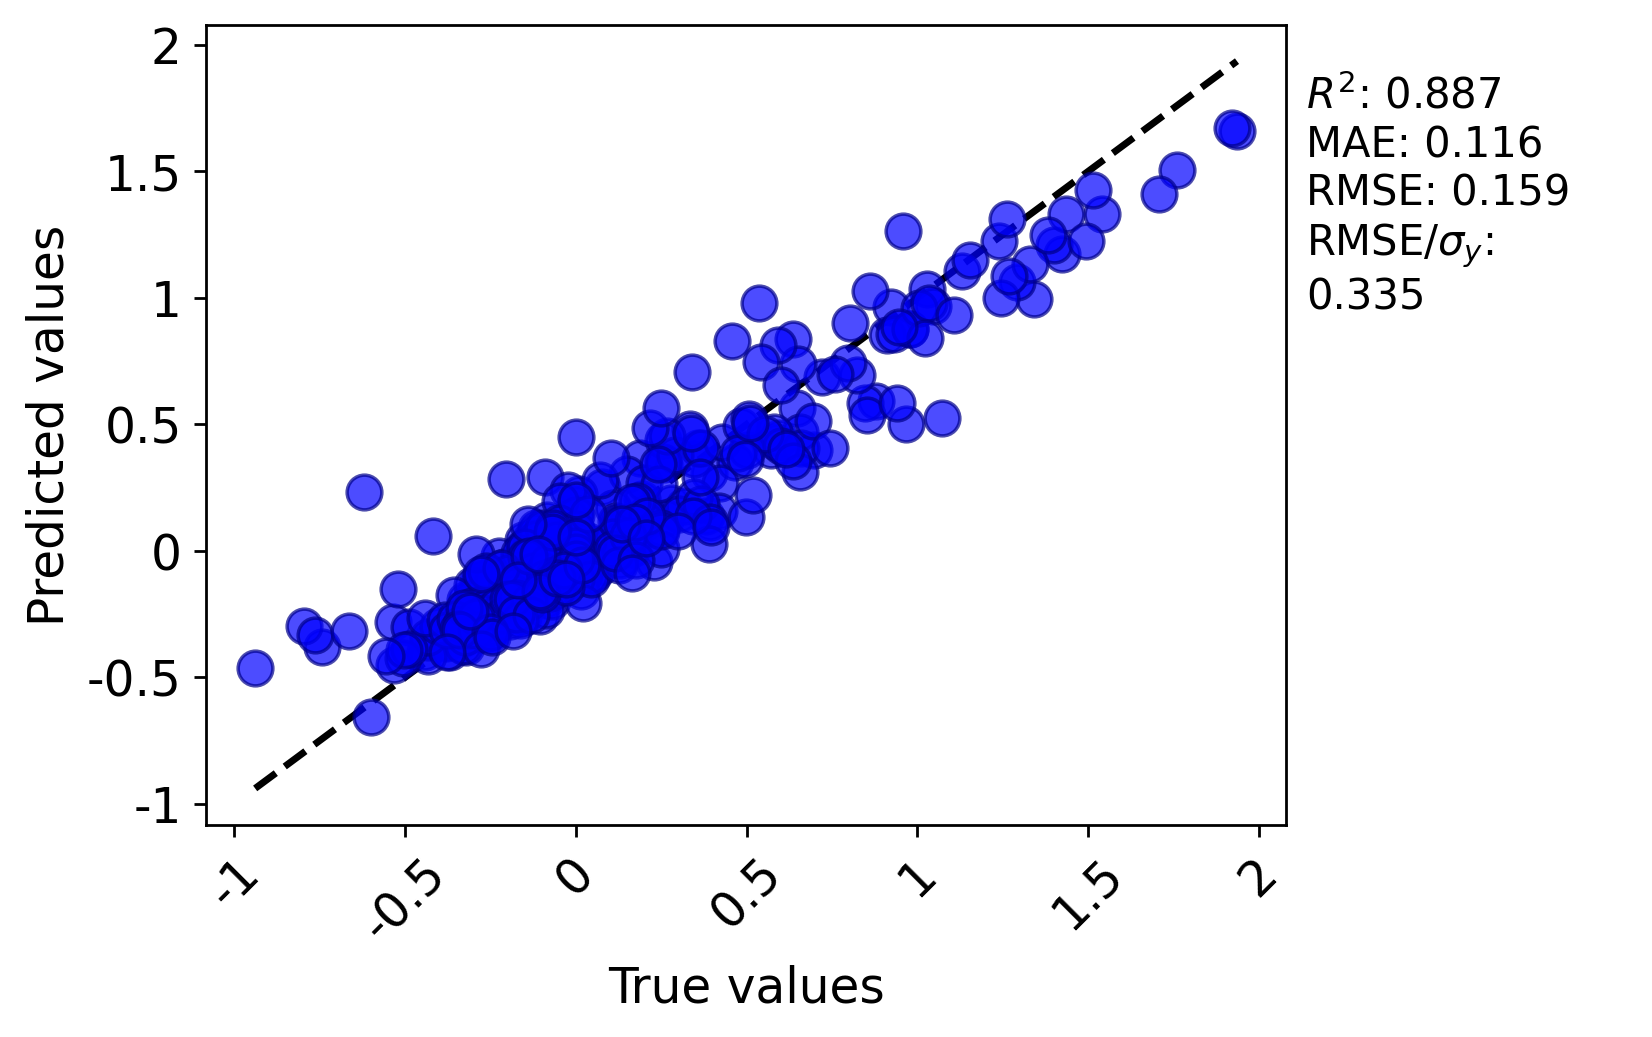


I found that GPR had the lowest average test RMSE of just 0.155 eV, with Random forest in close second at 0.159 eV.

## Task 3: Run a bootstrapped ensemble of neural networks <a name="task3"></a>

We just finished running a number of different types of models. One other type of 
flexible and quite generally powerful model is a bootstrapped ensemble model. We
previously already ran one of these- the random forest, which is a bootstrapped ensemble
of decision trees. However, we can create other types of bootstrap ensembles models
using the EnsembleModel() in MAST-ML. Here, let's build an ensemble of neural network models. We will explore the implications of using ensemble models for uncertainy
quantification in more detail in Tutorial 6.

Like the SklearnModel, we denote the model name as its string name (here: "MLPRegressor"); this is
the base estimator in our ensemble. Here, we will use 100 separate neural network models in our 
ensemble

In [16]:
model_ens = EnsembleModel(model='MLPRegressor', n_estimators=100, hidden_layer_sizes=(20, 10))

Let's perform random 5-fold cross validation with our new ensemble model.

In [17]:
splitter = SklearnDataSplitter(splitter='RepeatedKFold', n_repeats=1, n_splits=5)
splitter.evaluate(X=X,
                  y=y, 
                  models=[model_ens],
                  preprocessor=preprocessor,
                  metrics=metrics,
                  plots=['Scatter', 'Histogram'],
                  savepath=savepath,
                  X_extra=X_extra,
                  verbosity=3)

How does the ensemble of neural networks compare to the single neural network? From our previous set
of parity plots, we saw that the neural network had an RMSE of 0.214 eV. From this ensemble model
run, we see that the RMSE has dropped to just 0.153 eV! 

### Single Neural Network
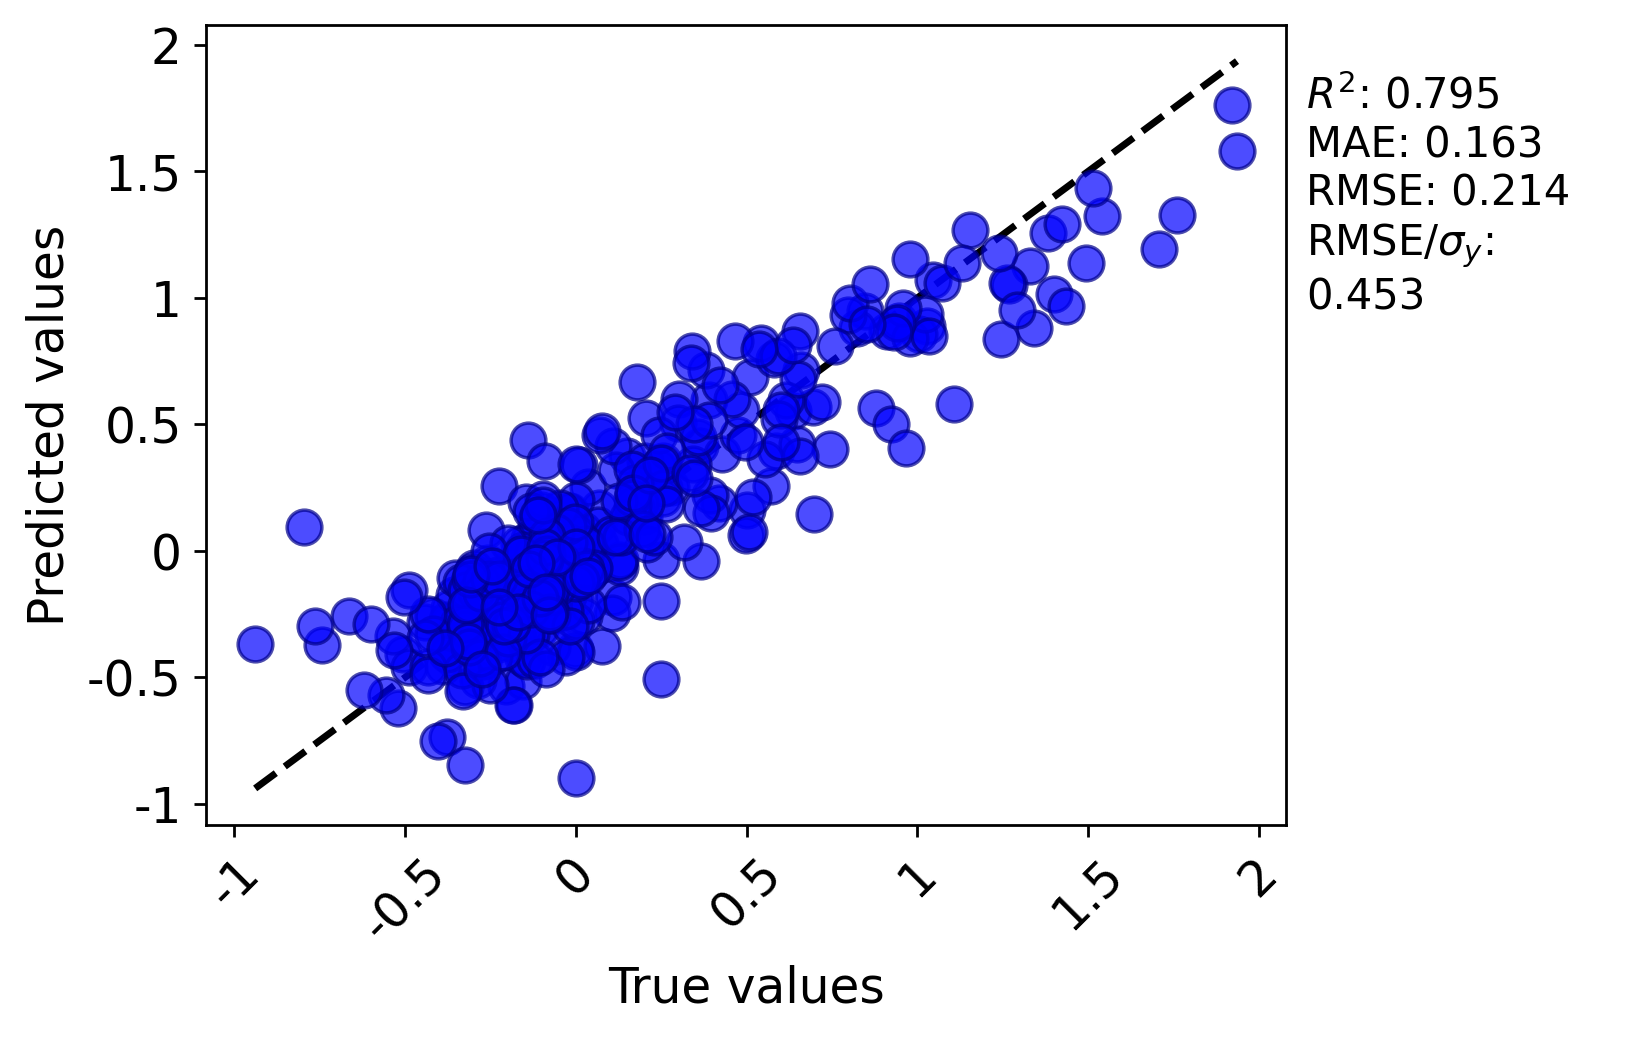

### Ensemble of Neural Networks

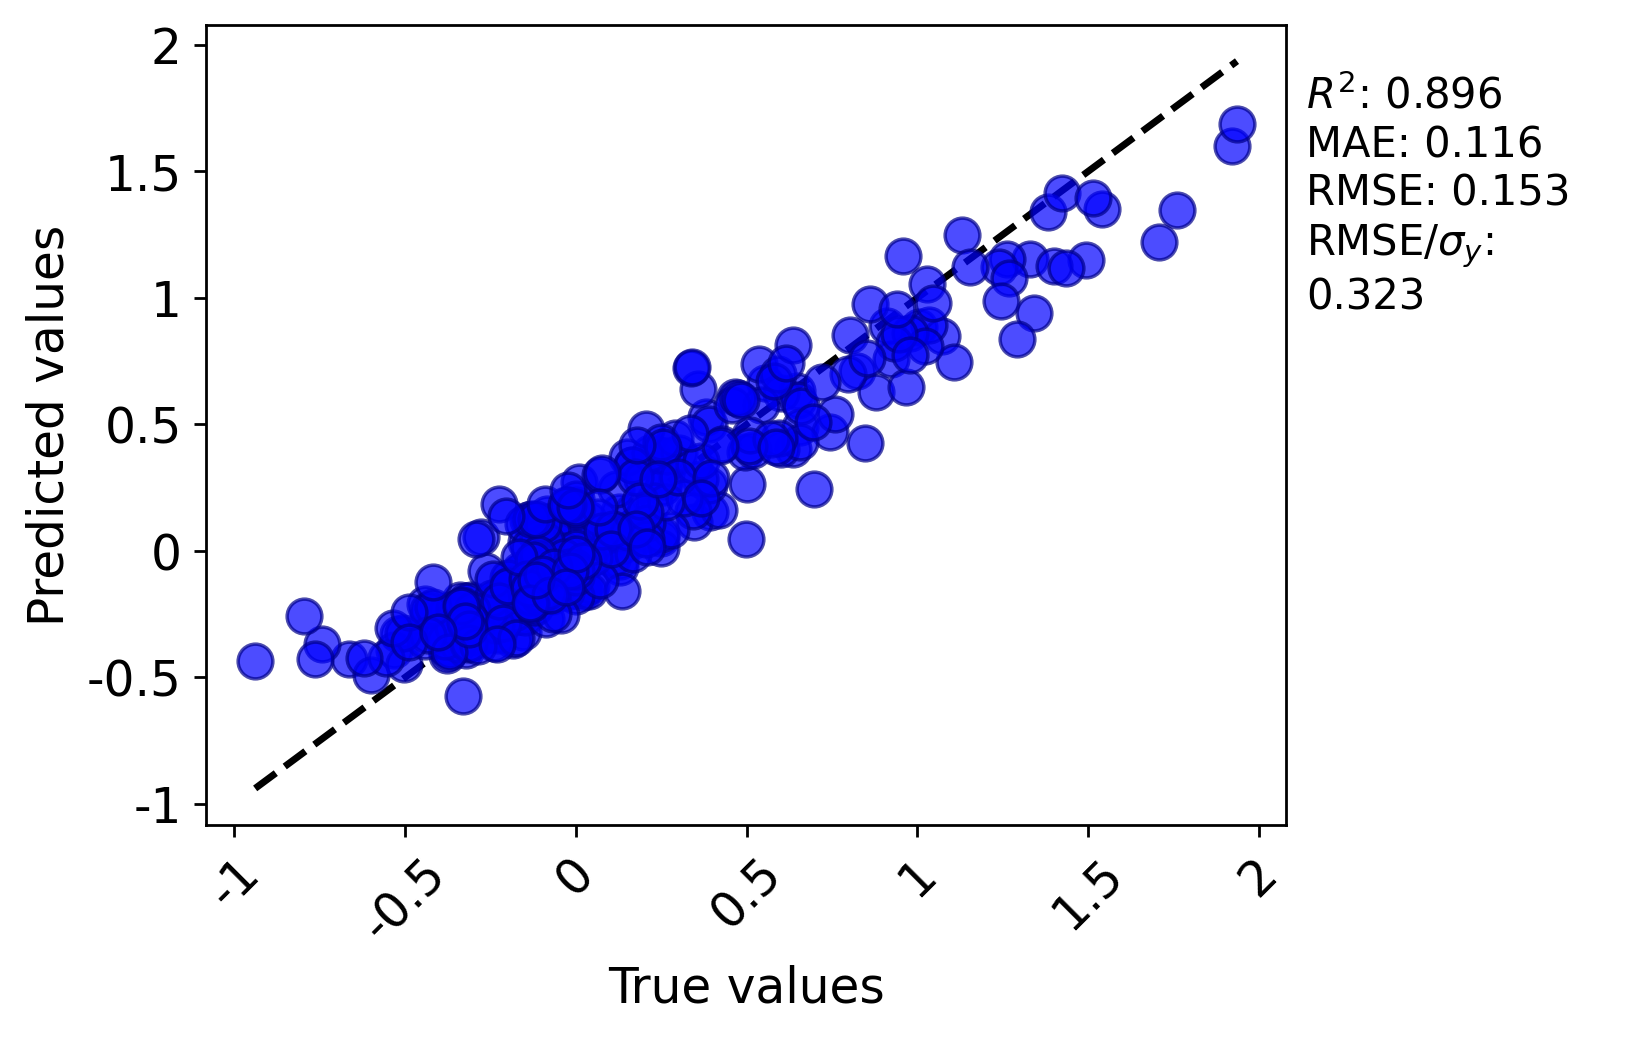

## Task 4: Compare performance of scikit-learn's gradient boosting method and XGBoost <a name="task4"></a>

Gradient boosted trees are a very popular type of regression model, and often are on par
or out-perform other tree-based methods. MAST-ML supports both scikit-learn's gradient
boosted regression model and the extreme boosting method in the XGBoost package. Let's run
5-fold cross validation test on each model and see which performs better! Do either of
the gradient boosting methods perform better than the random forest model you ran earlier?

In [18]:
model_gbr = SklearnModel(model='GradientBoostingRegressor', n_estimators=150)
model_xgb = SklearnModel(model='XGBoostRegressor', n_estimators=150)
models = [model_gbr, model_xgb]

splitter = SklearnDataSplitter(splitter='RepeatedKFold', n_repeats=1, n_splits=5)
splitter.evaluate(X=X,
                  y=y, 
                  models=models,
                  preprocessor=preprocessor,
                  metrics=metrics,
                  plots=['Scatter', 'Histogram'],
                  savepath=savepath,
                  X_extra=X_extra,
                  verbosity=3)

[22:37:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:37:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:37:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:37:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:37:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Let's see how the two models performed:

### Gradient boosting regression:
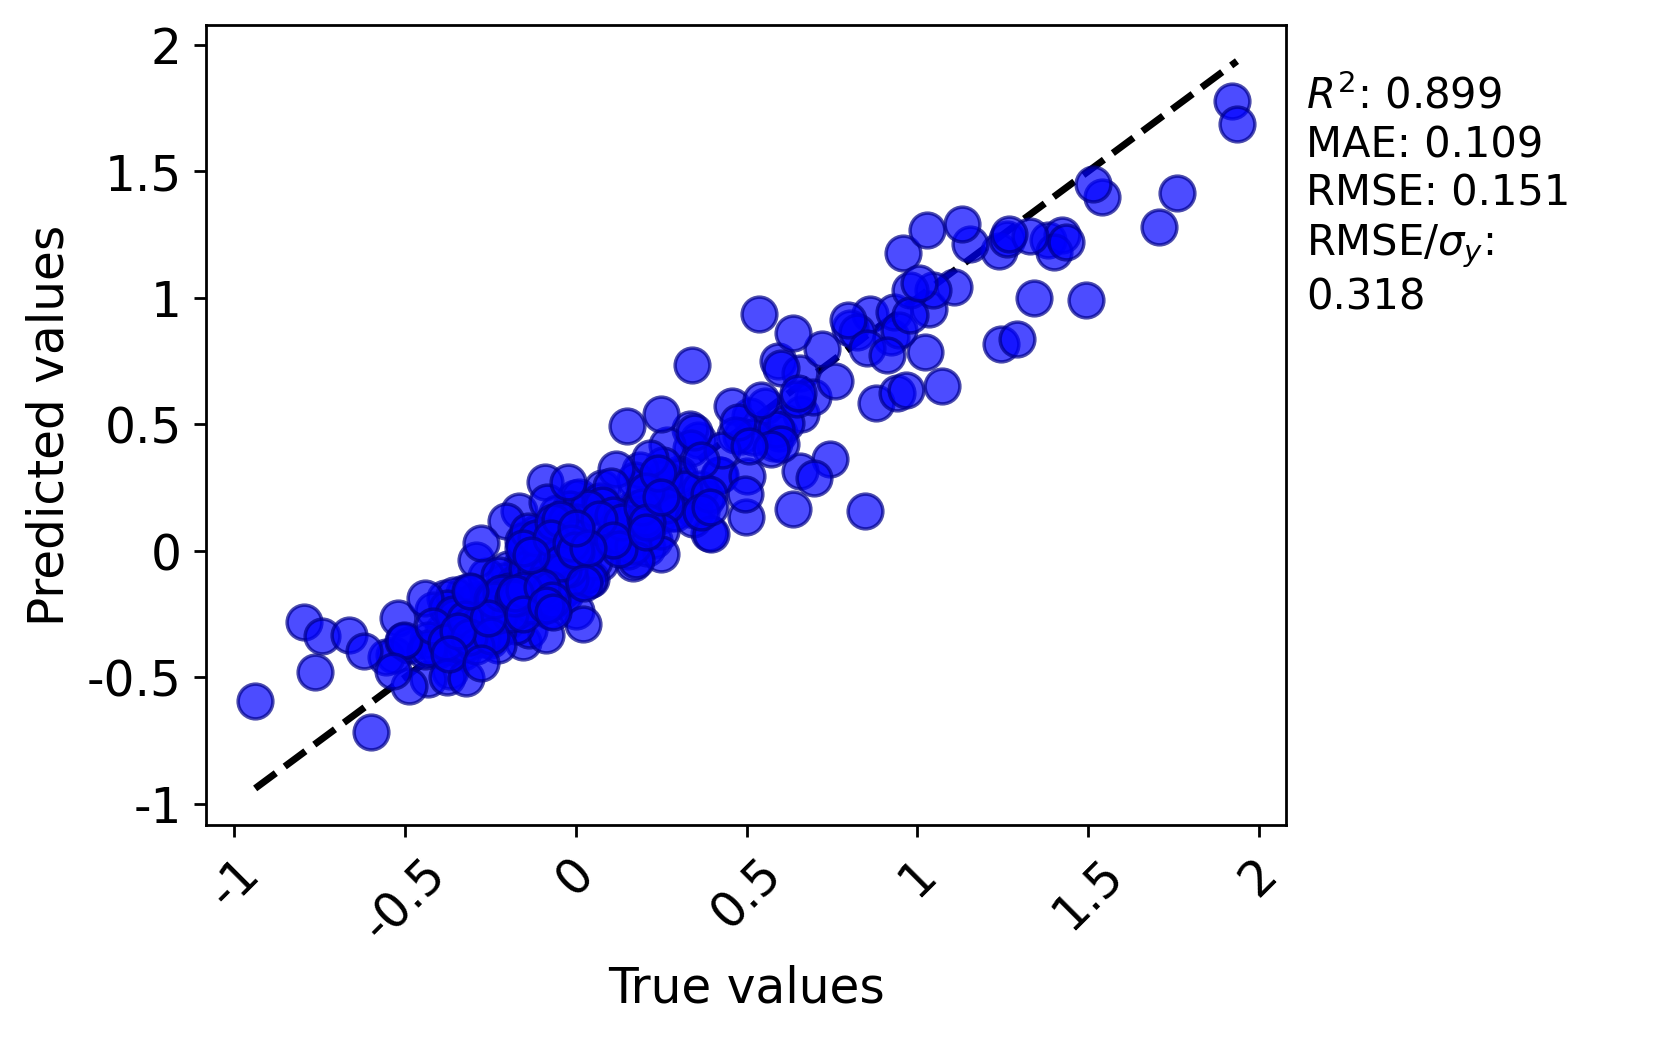

### XGBoost:
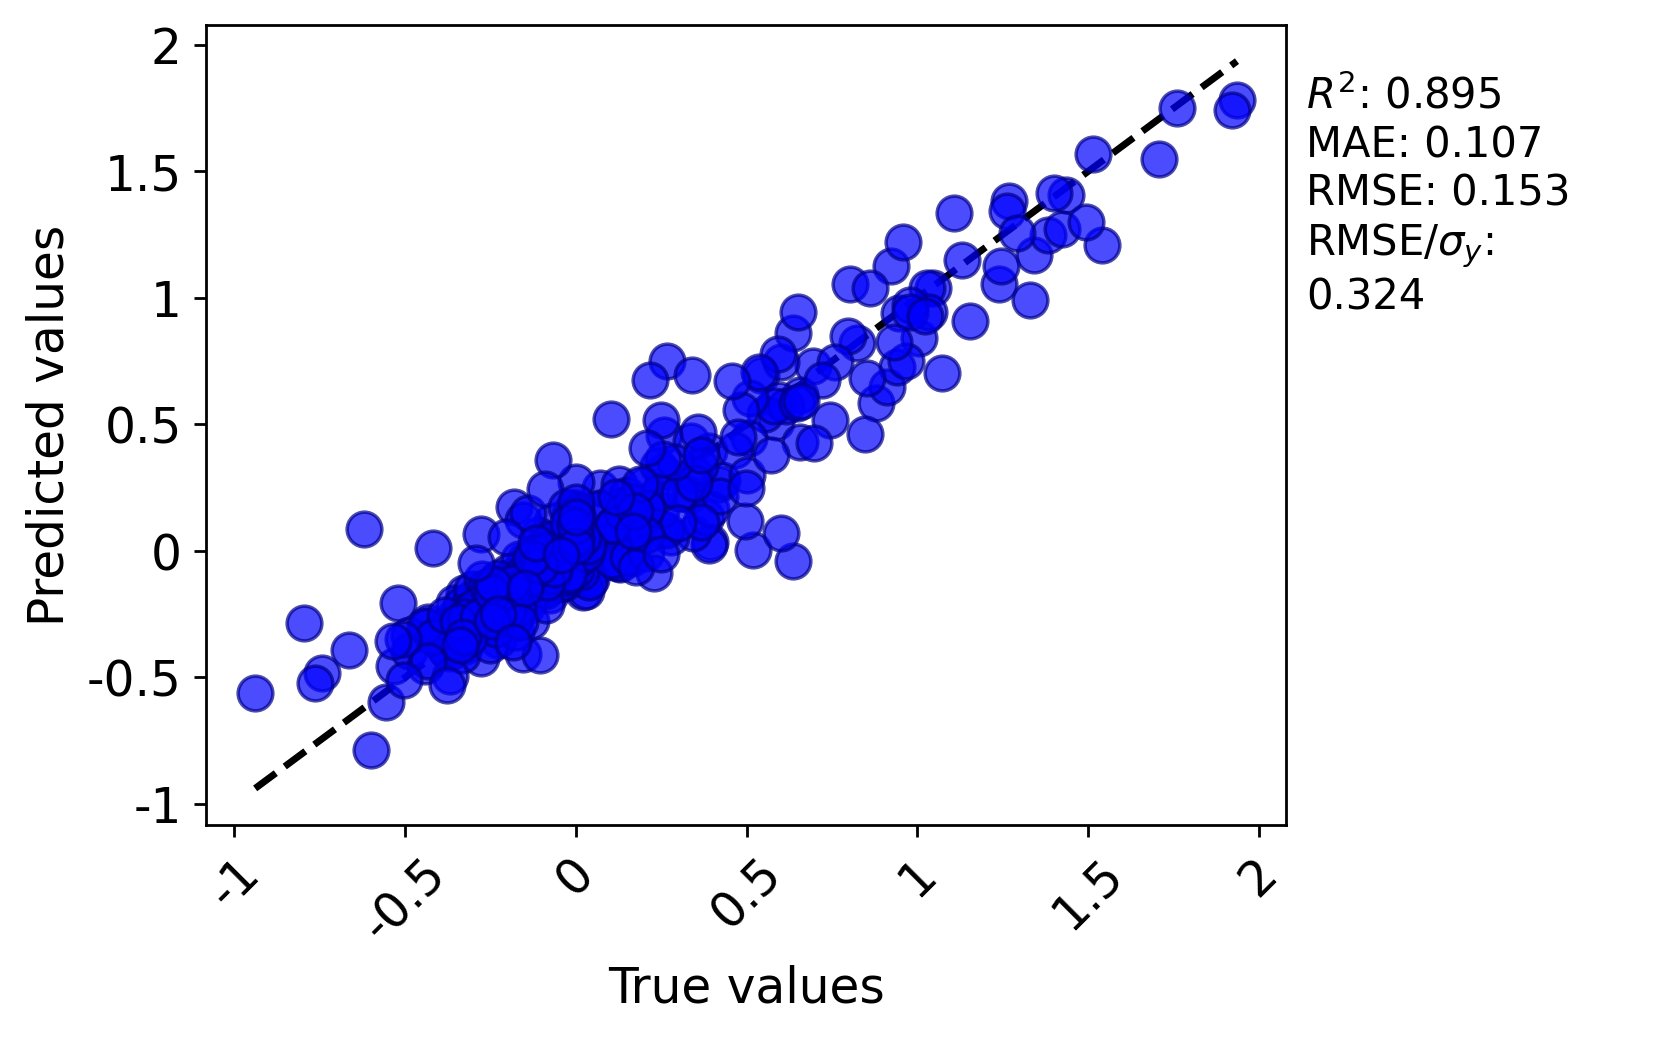

I found that GBR and XGB performed about the same- with test RMSE of about 0.150 eV. Both
of these models outperformed the random forest from earlier- which I found to have RMSE of 0.161 eV!

## Task 5: Compare performance of scikit-learn neural network and Keras-based neural network regressor <a name="task5"></a>

Due to their versatility and power, neural networks are among the most commonly used
regression models today. MAST-ML supports creating neural networks both from scikit-learn
and from Keras. We already ran the scikit-learn variant earlier, and it can be created with
a single line call:

In [5]:
model_nn = SklearnModel(model='MLPRegressor', hidden_layer_sizes=(20, 10))

Creating a Keras-based neural network for use in MAST-ML is a little more complicated, but can 
still be done with just a handful of lines. Keras offers the ability to make its models function
like scikit-learn models, so we use that functionality here.

In [6]:
# Import a few needed modules from Keras to build the network
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor

# We need to define the function that builds the network architecture
def keras_model():
    model = Sequential()
    model.add(Dense(20, input_dim=20, kernel_initializer='normal', activation='relu'))
    model.add(Dense(10, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

Now we build the keras model that will be passed into MAST-ML. The build_fn parameter
designates the "build function", i.e. the function used to build the network architecture,
which we defined above.

In [7]:
model_keras = KerasRegressor(build_fn=keras_model, epochs=100, batch_size=100, verbose=0)

Now that we've built both of our model types, we can run each of them using
our random 5-fold cross validation test. 

In [ ]:
models = [model_nn, model_keras]
splitter = SklearnDataSplitter(splitter='RepeatedKFold', n_repeats=1, n_splits=5)
splitter.evaluate(X=X,
                  y=y, 
                  models=models,
                  preprocessor=preprocessor,
                  metrics=metrics,
                  plots=['Scatter', 'Histogram'],
                  savepath=savepath,
                  X_extra=X_extra,
                  verbosity=3)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



Which neural network performs better? Let's examine the parity plots for each:

### Scikit-learn Neural Network:
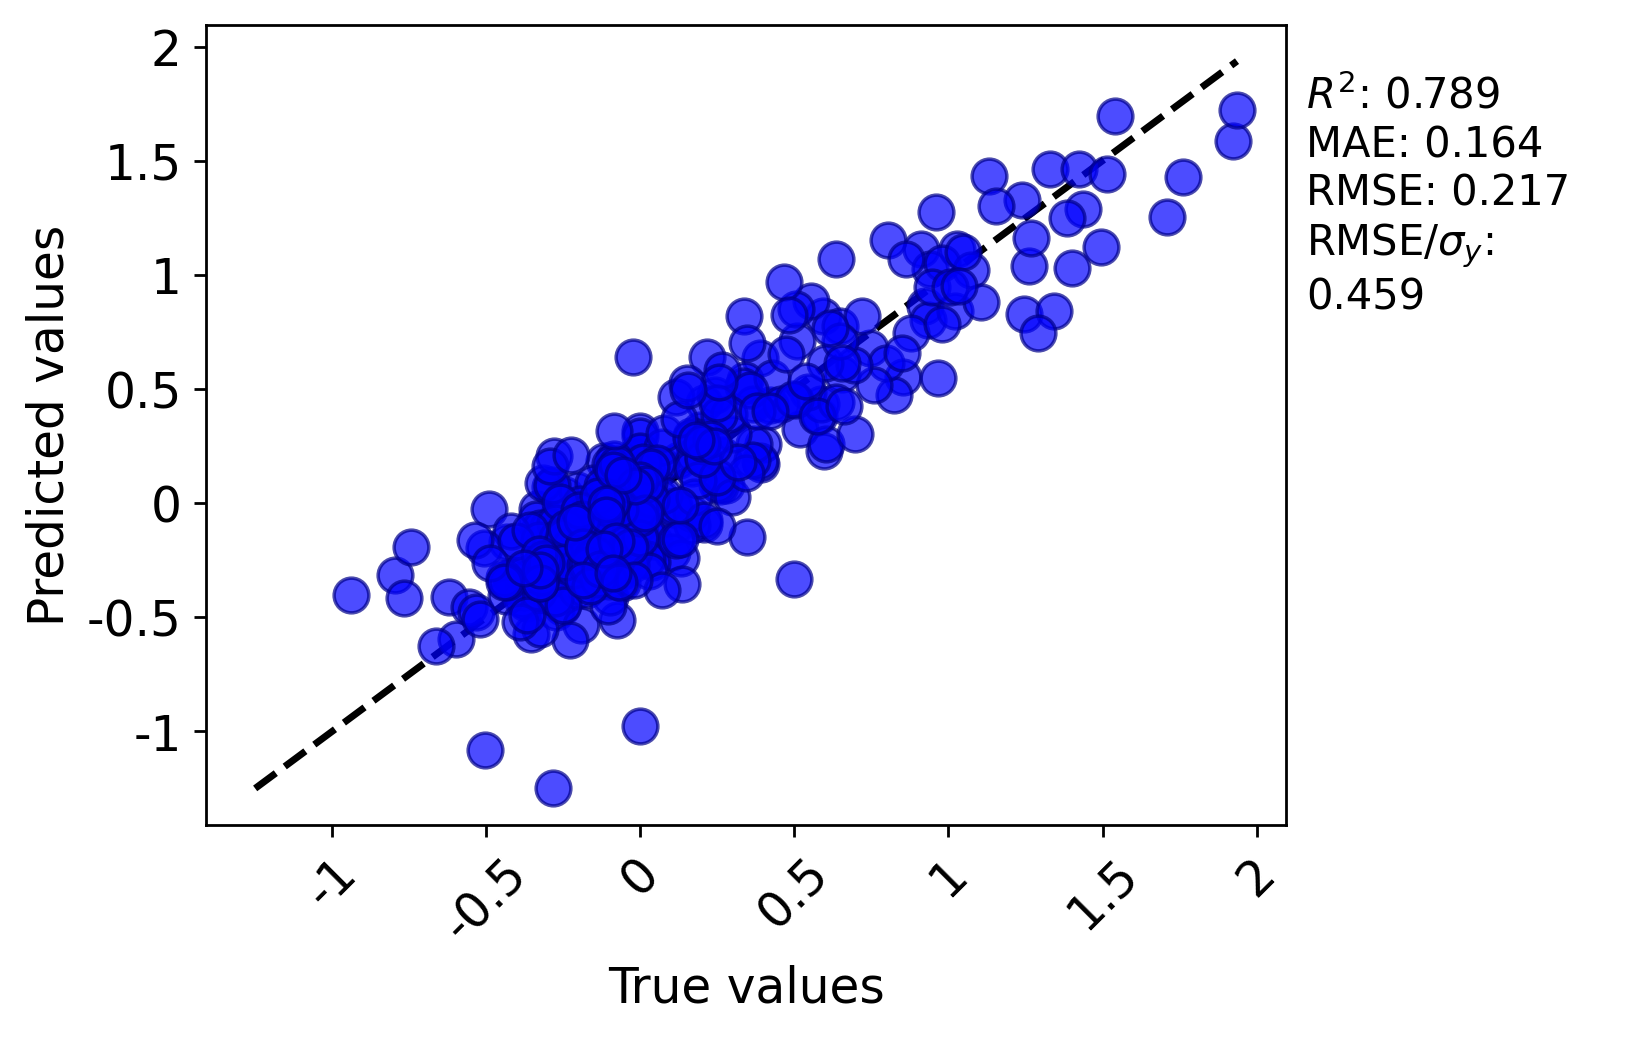

### Keras Neural Network:
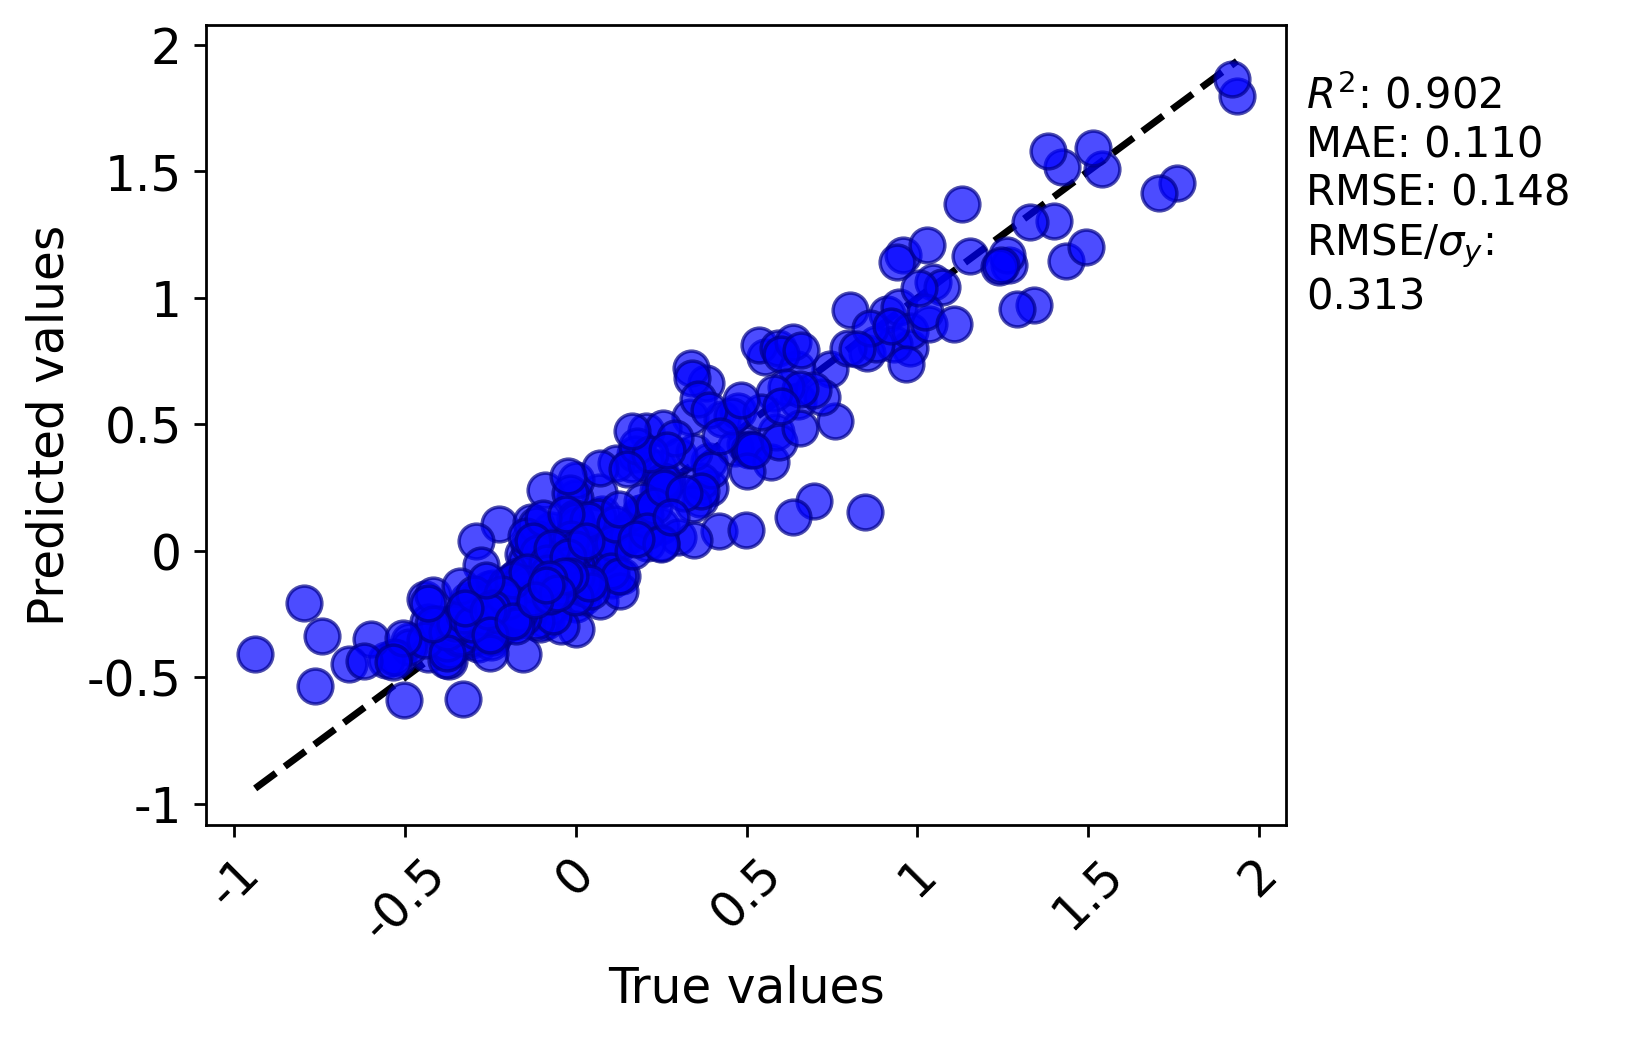
    
In my test, it was no contest. The scikit-learn MLPRegressor had a test RMSE of 0.217 eV while the Keras network had an RMSE of only 0.148 eV!

## Task 6: Compare model performance using random k-fold cross validation and leave out group cross validation <a name="task6"></a>

So far we have only done two types of data splitter test: the most basic test where no split is
performed and we fit to all the data, and a random leave-out cross validation test. However,
many datasets have subsets of data that belong to distinct groups, and one is often interested in
how a model may perform when predicting new data on a brand new group. The diffusion data has
logical set of groups based on the host metal element, which is denoted in the 'Material compositions 1'
column of our data set and is designated in the groups variable when we imported the data. There are
15 unique groups (metal hosts) in our current case:

In [23]:
import numpy as np
np.unique(groups)

array(['Ag', 'Al', 'Au', 'Ca', 'Cu', 'Fe', 'Ir', 'Mg', 'Mo', 'Ni', 'Pb',
       'Pd', 'Pt', 'W', 'Zr'], dtype=object)

Let's focus on using a random forest model and use this model to run two tests:
random 5-fold cross validation and leave out group cross validation:

In [24]:
model_rf = SklearnModel(model='RandomForestRegressor', n_estimators=150)
splitter_random = SklearnDataSplitter(splitter='RepeatedKFold', n_repeats=1, n_splits=5)
splitter_groups = SklearnDataSplitter(splitter='LeaveOneGroupOut')

splitter_random.evaluate(X=X, 
                         y=y, 
                         models=[model_rf],
                         preprocessor=preprocessor,
                         metrics=metrics,
                         plots=['Scatter', 'Histogram'],
                         savepath=savepath,
                         X_extra=X_extra,
                         verbosity=3)

splitter_groups.evaluate(X=X, 
                         y=y, 
                         groups=groups,
                         models=[model_rf],
                         preprocessor=preprocessor,
                         metrics=metrics,
                         plots=['Scatter', 'Histogram'],
                         savepath=savepath,
                         X_extra=X_extra,
                         verbosity=3)

Which test resulted in the higher error? Why do you think this is the case?

### Random leave-out:
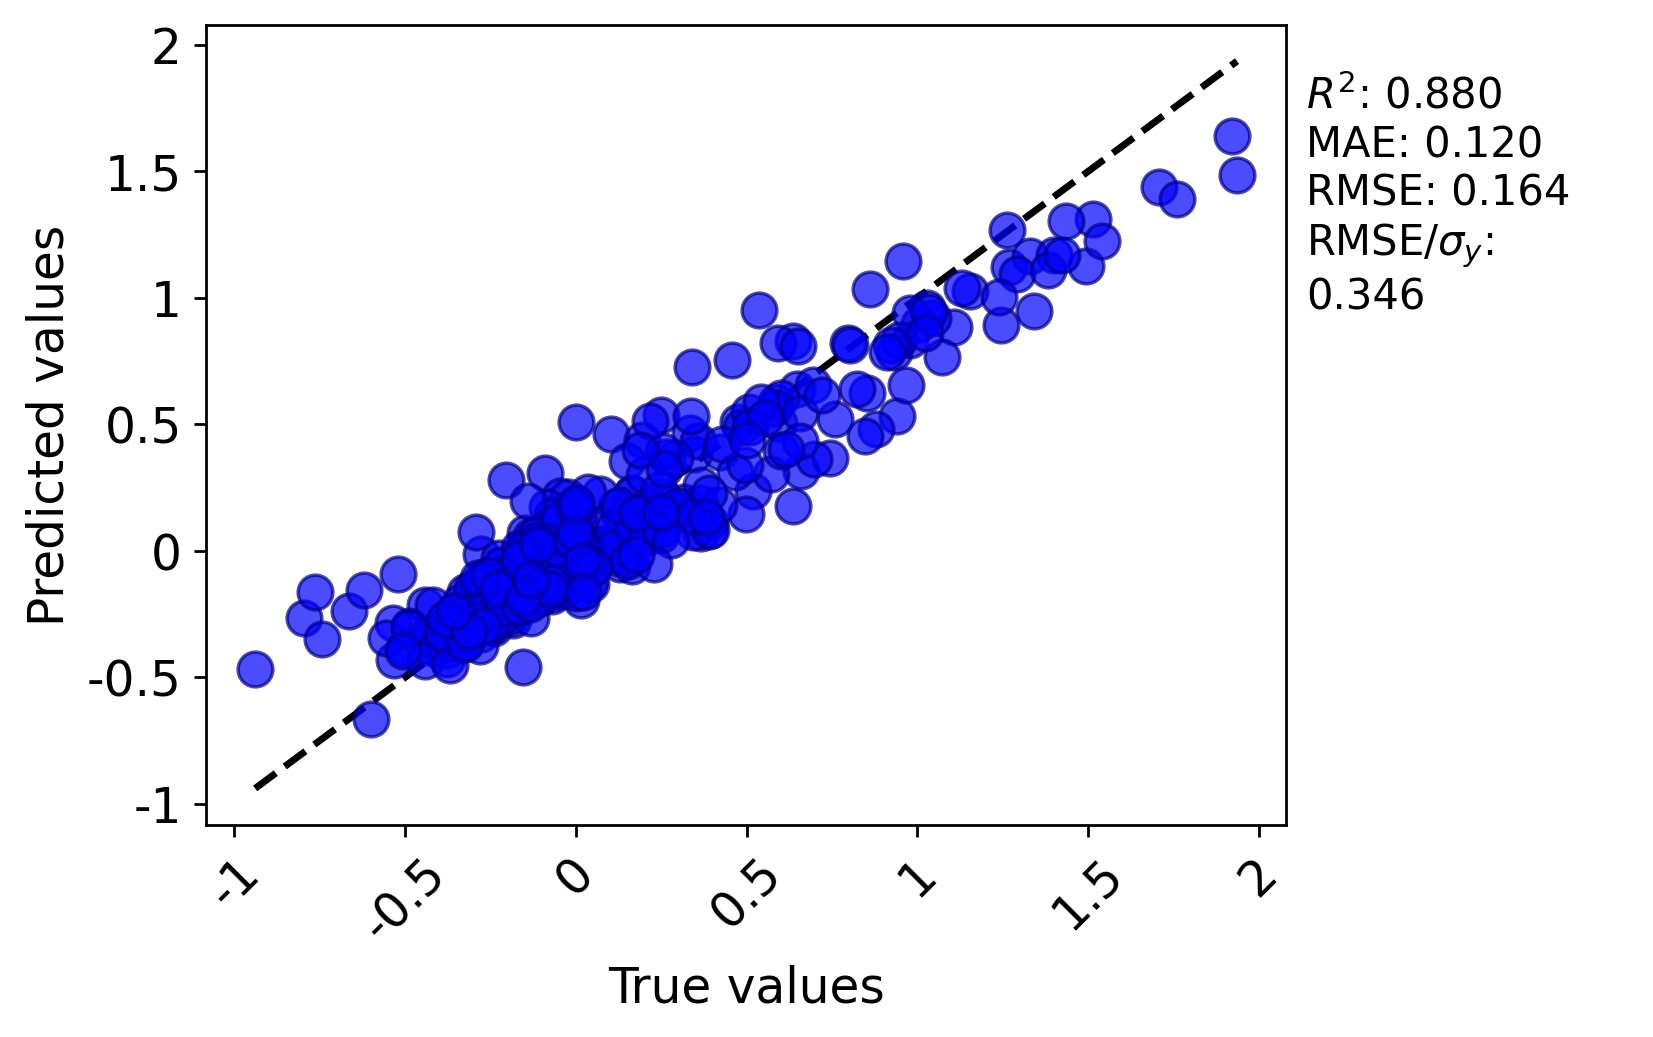

### Leave out group:
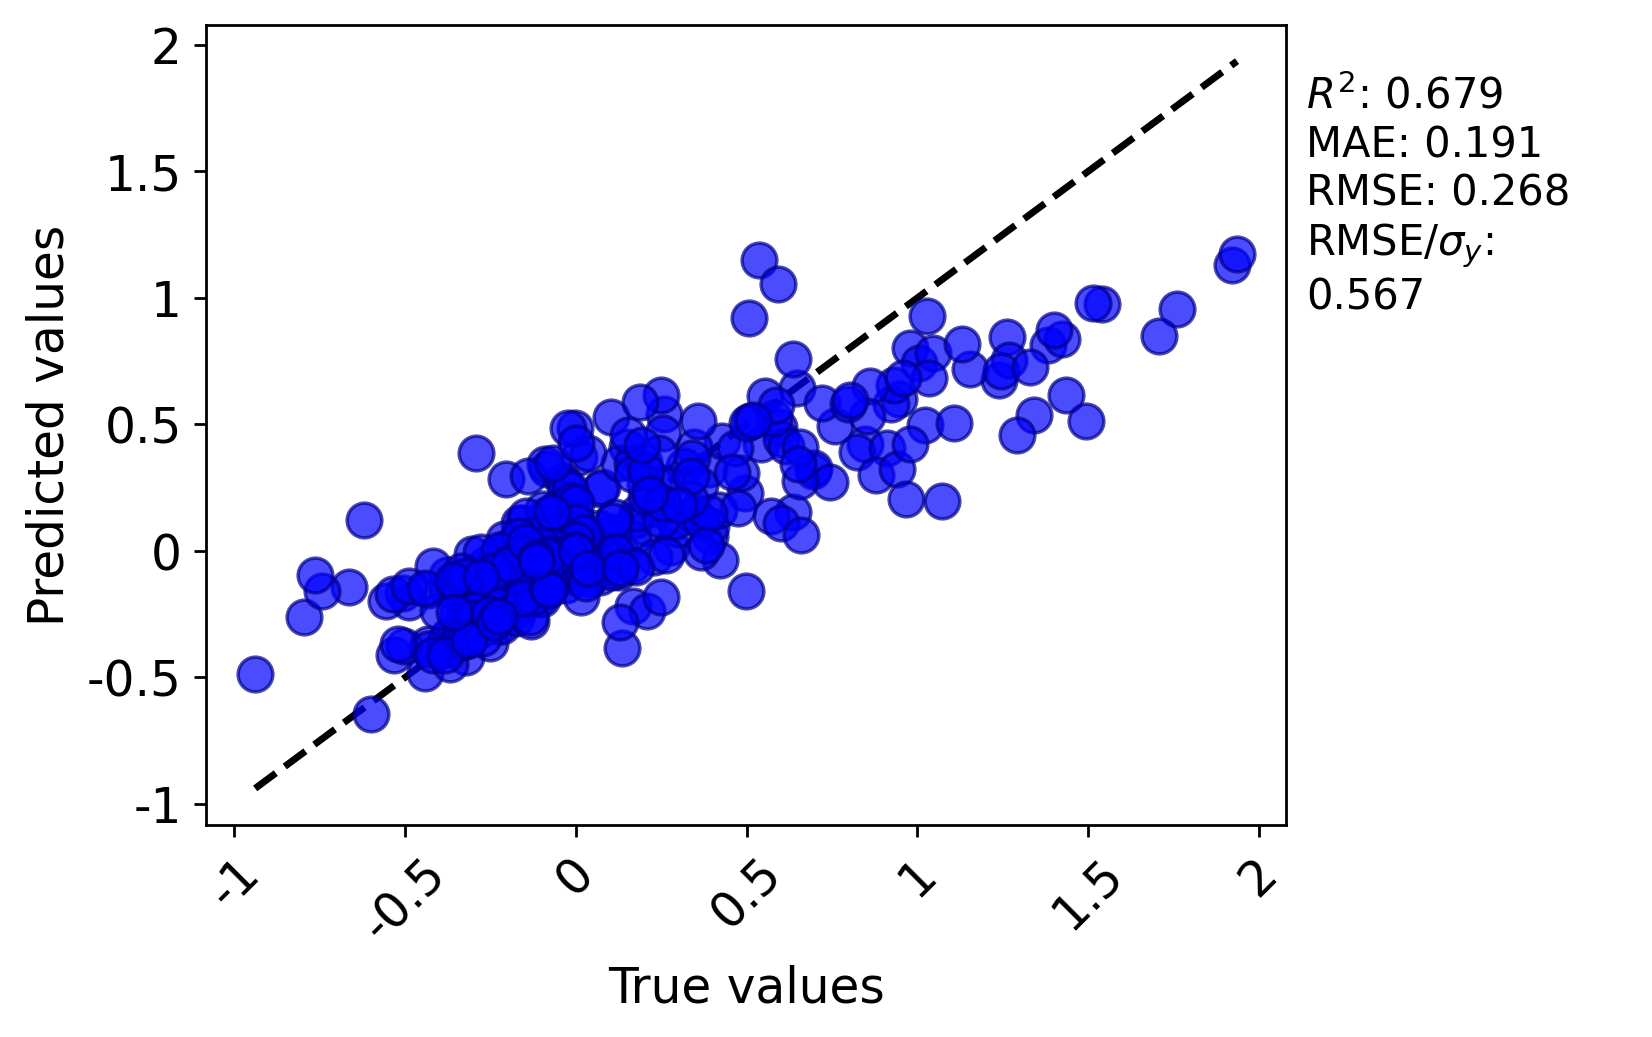

I found that the leave out group splitter had a higher error with a test
RMSE of about 0.268 eV compared to 0.164 eV for the random cross validation test.

For leave out group tests, MAST-ML also provides plots of each error metric value vs. group. From this, we can 
see that Mo had the best fit while Zr and Pt had rather poor fits.

### RMSE vs Group:
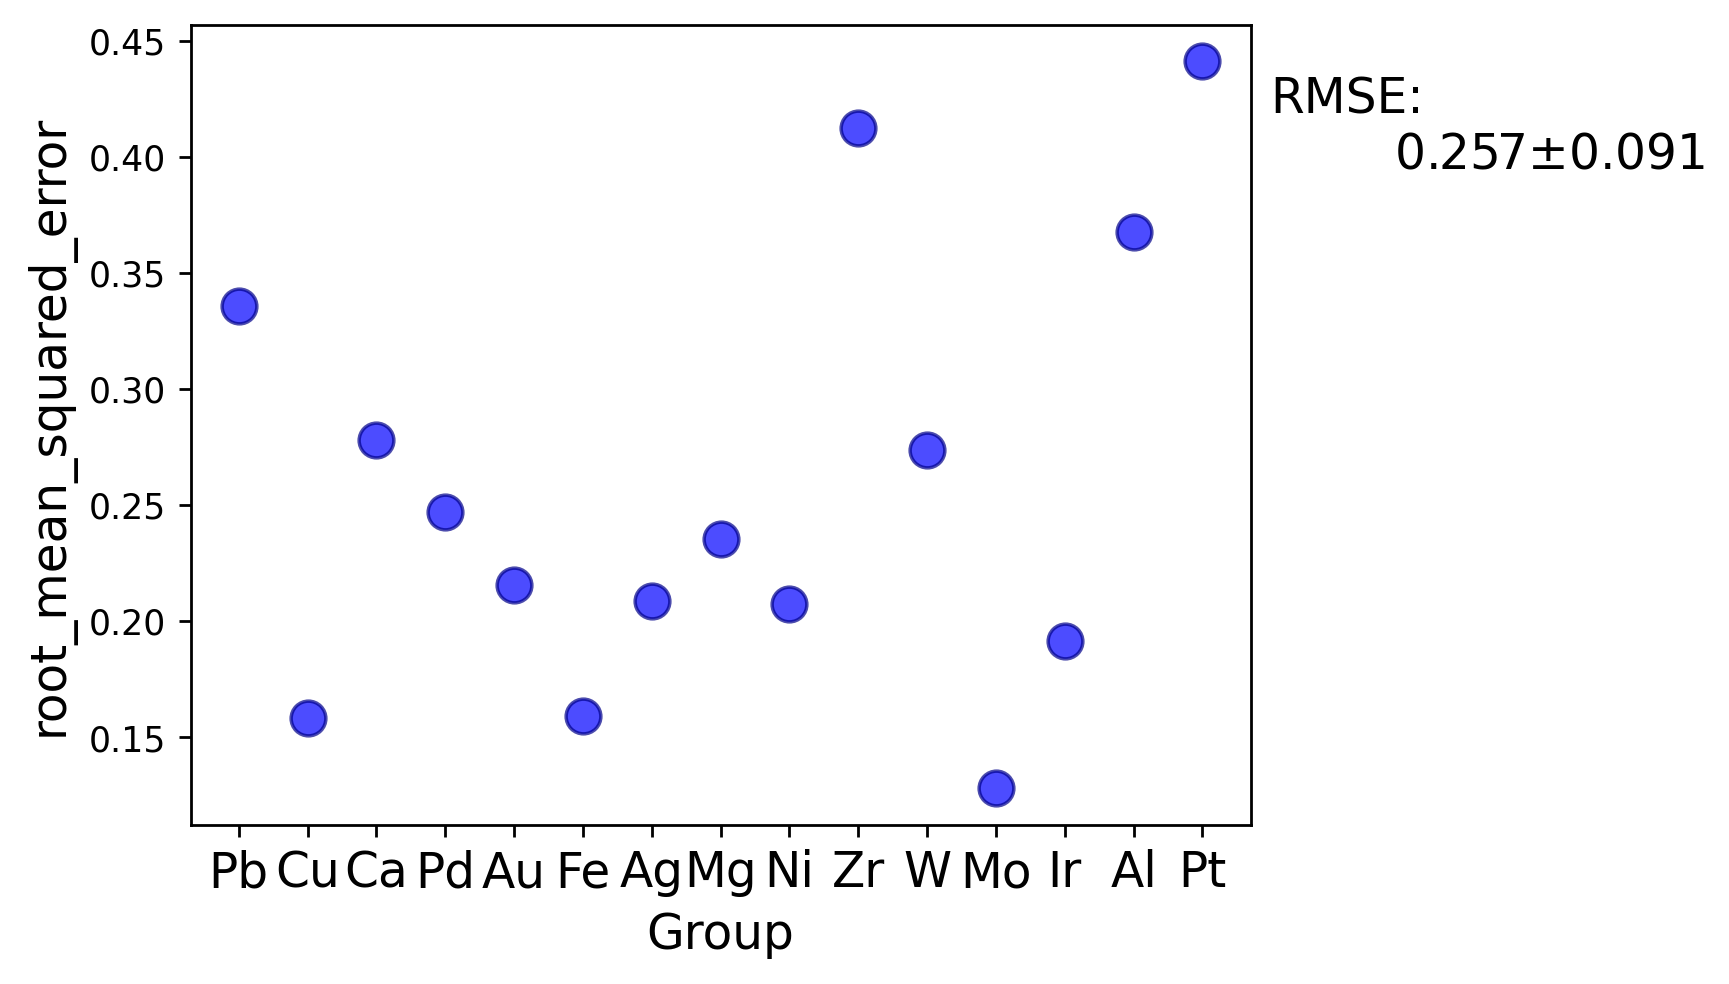


## Task 7: Explore the limits of model performance when up to 90% of data is left out using leave out percent cross validation <a name="task7"></a>

As one final data splitter test in this tutorial, we can see how well (or poorly) our
model performs as we hold out more and more data. Typical K-fold CV only allows for 
holding out up to 50% of the data (2-fold CV). Here, we use LeaveOutPercent to leave
out up to 90% of our data. Let's define several increments of different leave out percent
tests, then fit a Kernel ridge model to each and see how the test RMSE changes as more
data is left out:

In [25]:
model_gkrr = SklearnModel(model='KernelRidge', kernel='rbf')

splitter_10percent = LeaveOutPercent(percent_leave_out=0.1, n_repeats=5)
splitter_25percent = LeaveOutPercent(percent_leave_out=0.25, n_repeats=5)
splitter_50percent = LeaveOutPercent(percent_leave_out=0.5, n_repeats=5)
splitter_75percent = LeaveOutPercent(percent_leave_out=0.75, n_repeats=5)
splitter_90percent = LeaveOutPercent(percent_leave_out=0.9, n_repeats=5)

splitter_10percent.evaluate(X=X,
                            y=y, 
                            models=[model_gkrr],
                            preprocessor=preprocessor,
                            metrics=metrics,
                            plots=['Scatter', 'Histogram'],
                            savepath=savepath,
                            X_extra=X_extra,
                            verbosity=3)
splitter_25percent.evaluate(X=X,
                            y=y, 
                            models=[model_gkrr],
                            preprocessor=preprocessor,
                            metrics=metrics,
                            plots=['Scatter', 'Histogram'],
                            savepath=savepath,
                            X_extra=X_extra,
                            verbosity=3)
splitter_50percent.evaluate(X=X,
                            y=y, 
                            models=[model_gkrr],
                            preprocessor=preprocessor,
                            metrics=metrics,
                            plots=['Scatter', 'Histogram'],
                            savepath=savepath,
                            X_extra=X_extra,
                            verbosity=3)
splitter_75percent.evaluate(X=X,
                            y=y, 
                            models=[model_gkrr],
                            preprocessor=preprocessor,
                            metrics=metrics,
                            plots=['Scatter', 'Histogram'],
                            savepath=savepath,
                            X_extra=X_extra,
                            verbosity=3)
splitter_90percent.evaluate(X=X,
                            y=y, 
                            models=[model_gkrr],
                            preprocessor=preprocessor,
                            metrics=metrics,
                            plots=['Scatter', 'Histogram'],
                            savepath=savepath,
                            X_extra=X_extra,
                            verbosity=3)

How does the test RMSE change as more data is left out? For my case, I found the following:

LO 10%: 0.148 eV 

LO 25%: 0.155 eV

LO 50%: 0.183 eV
    
LO 75%: 0.216 eV

LO 90%: 0.282 eV

Not surprisingly, the model becomes worse as less data is used for training. The minimum amount
of data needed to obtain what constitutes good model performance will be application specific.

You've now completed your fourth MAST-ML tutorial notebook! Now that you're more familiar with working
with different types of models and cross validation tests to evaluate those models, we are ready to 
move on to some more advanced fitting methods, like nested cross validation and model optimization

The next example in this notebook series is titled MASTML_Tutorial_5_NestedCV_and_OptimizedModels.ipynb, 
and will guide you through the process of assessing model performance on true test data, and generating the
best optimized model for a specified cross validation test